# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

## Point and Directional Forecasts

**Imports**

In [9]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown

In [10]:
OUT_DIR = "../out"         
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (72662, 10)
df_full shape: (84110, 10)


## 3.0: Baseline static forecast on full sample

Rolling 6-month fixed window. For every valid economist (for a prediction at time t, has a contiguous 6-month forecast history for previous 6 releases), weight prediction by inverse MSE. 


This implements an out-of-sample error estimate with a rolling 6-month estimation window. Weights don't use information from the target month and actual value at month *t* is unseen. In other words, all errors are "live" errors that could have been observed in real time.

Briefly, the procedure: 
1. Starts at 7th release (for 6 month release prior)
2. From estimation window, keep economists that supplied a forecast for all six months (per contiguity rule)
3. Compute MSE for each economist using errors against already known actuals (no lookahead)
4. Generate forecast for release t 
5. Store OOS evaluation error
6. Roll window forward a month and repeat

RMSE – smart : 667.95 k jobs
RMSE – median: 676.12 k jobs
DM statistic :  -0.91
p-value      : 0.3602


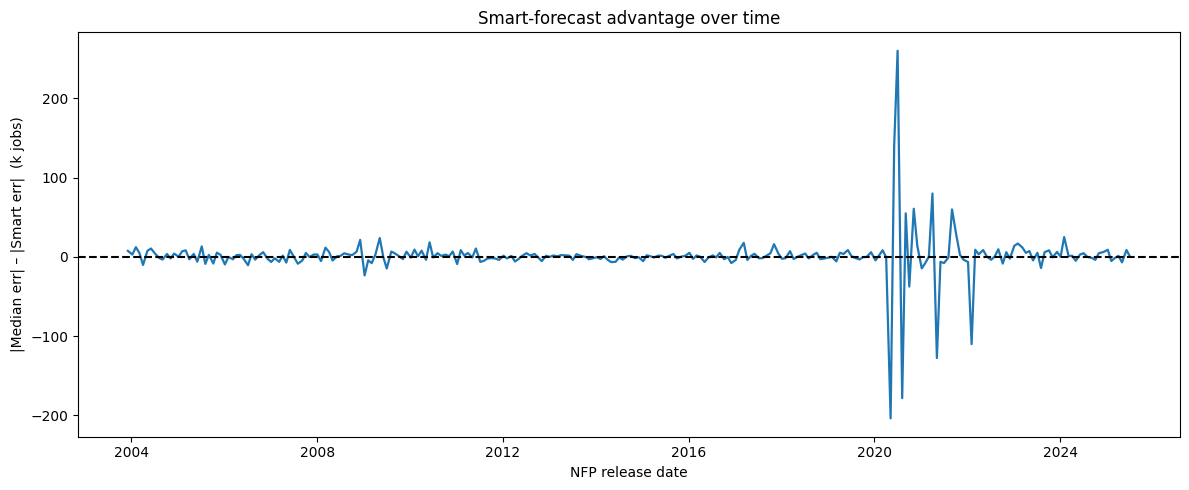


Latest unreleased forecast rows (actual is NaN):


,date,smart,median,actual


In [11]:
# ------------------------------------------------------------
# 1. Build smart & median forecasts for every release
#    (evaluation window = previous 6 releases)
# ------------------------------------------------------------
dates    = np.sort(df_full["release_date"].unique())
records  = []                         # collect all forecasts (even unreleased)

for idx in range(6, len(dates)):
    t_date  = dates[idx]              # target month
    window  = dates[idx-6:idx]        # six-month look-back

    # historical panel for weight estimation
    hist = df_full[df_full["release_date"].isin(window)]

    # economists with forecasts in every month of the window
    contig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs  = contig[contig].index
    if econs.empty:
        continue

    # inverse-MSE weights
    mse = (hist[hist["economist"].isin(econs)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(np.square(s))))
    ridge   = 1e-6
    weights = 1.0 / (mse + ridge)
    weights /= weights.sum()

    # current-month forecasts, align & renormalise
    cur     = df_full[(df_full["release_date"] == t_date) &
                      (df_full["economist"].isin(econs))]
    f_t     = cur.set_index("economist")["forecast"].dropna()
    weights = weights.reindex(f_t.index).dropna()
    if weights.empty:
        continue
    weights /= weights.sum()

    # point forecasts
    smart   = np.dot(weights, f_t.loc[weights.index])
    median  = df_full.loc[df_full["release_date"] == t_date,
                          "forecast"].dropna().median()
    actual  = df_full.loc[df_full["release_date"] == t_date,
                          "actual"].iloc[0]          # may be NaN (e.g. July-25)

    records.append((t_date, smart, median, actual))

# ------------------------------------------------------------------
# 2. Split into “all” vs “evaluation” sets
# ------------------------------------------------------------------
oos_all  = pd.DataFrame(records,
                        columns=["date", "smart", "median", "actual"])
oos_eval = oos_all.dropna(subset=["actual"]).copy()     # evaluation sample

# ------------------------------------------------------------------
# 3. Evaluation metrics (only rows with realised actuals)
# ------------------------------------------------------------------
oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]

rmse_smart  = np.sqrt((oos_eval["smart_err"]**2).mean())
rmse_median = np.sqrt((oos_eval["median_err"]**2).mean())
print(f"RMSE – smart : {rmse_smart:6.2f} k jobs")
print(f"RMSE – median: {rmse_median:6.2f} k jobs")

# Diebold-Mariano test on squared-error loss
d        = oos_eval["smart_err"]**2 - oos_eval["median_err"]**2
dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
print(f"DM statistic : {dm_stat:6.2f}")
print(f"p-value      : {dm_p:.4f}")

# ------------------------------------------------------------------
# 4. Visualise improvement timeline (evaluation sample)
# ------------------------------------------------------------------
oos_eval["improvement"] = (oos_eval["median_err"].abs() -
                           oos_eval["smart_err"].abs())

plt.figure(figsize=(12, 5))
plt.plot(oos_eval["date"], oos_eval["improvement"],
         lw=1.6, color="tab:blue")
plt.axhline(0, ls="--", c="k")
plt.title("Smart-forecast advantage over time")
plt.xlabel("NFP release date")
plt.ylabel("|Median err| – |Smart err|  (k jobs)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. (Optional) Inspect the unreleased month’s forecasts
# ------------------------------------------------------------------
print("\nLatest unreleased forecast rows (actual is NaN):")
display(oos_all[oos_all["actual"].isna()])


Noticeably erratic performance in COVID and subsequent aftermath (~2020-2022). Pertinent to subset out as 2020-2022 is unlikely to be generalizable to future performance.

## 3.1: Static Forecast, inverse-MSE weighted

Here, in addition to the level forecast, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 3, 6, 12, and 24 months

- We evaluate every static-ensemble variant on both the full panel (df_full) and COVID-filtered panel (df)
- Apply the robust-winner rule on the COVID-filtered panel (winner is method that has lowest RMSE_smart that satisfies DM_p < 0.10, Binom_p < 0.10, PT_p < 0.10)
- Print historical evaluation tables for both panels, then produce a live forecast (if applicable) for upcoming release

In [25]:
# ─────────────────────────── settings ───────────────────────────
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

# helper ─────────────────────────────────────────────────────────
def run_static_panel(df_panel: pd.DataFrame, name: str):
    dates = np.sort(df_panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(contiguity_windows, methods),
                               total=len(contiguity_windows)*len(methods),
                               desc=f"{name} grid"):

        preds = []                     # per-release records
        for idx in range(window, len(dates)):
            t = dates[idx]
            # ----- look-back slice -----
            hist = df_panel[df_panel["release_date"].isin(dates[idx-window:idx])]
            # economists with all forecasts in window
            econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = econs[econs].index
            if econs.empty:  continue

            if method == "equal_weight":
                w = pd.Series(1.0, index=econs)
            else:
                grp = hist[hist["economist"].isin(econs)].groupby("economist")["error"]
                score = grp.apply(lambda s: np.nanmean(s**2) if method=="inverse_mse"
                                  else np.nanmean(np.abs(s)))
                w = 1.0/(score+ridge)
            w /= w.sum()

            # ----- current forecasts -----
            cur = df_panel[(df_panel["release_date"]==t) & (df_panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:  continue
            w /= w.sum()

            smart  = np.dot(w, f_t.loc[w.index])
            median = df_panel.loc[df_panel["release_date"]==t, "forecast"].dropna().median()
            actual = df_panel.loc[df_panel["release_date"]==t, "actual"].iloc[0]
            preds.append((t, smart, median, actual))

        # nothing for this (window,method)?
        if not preds:  continue

        oos = pd.DataFrame(preds, columns=["date","smart","median","actual"])

        # save unreleased forecast (if latest actual is NaN)
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append({"panel" : name,
                              "window": window,
                              "method": method,
                              "date"  : last["date"],
                              "smart" : last["smart"],
                              "median": last["median"],
                              "pred_dir": int(last["smart"] > last["median"]) })

        # evaluation on realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:  continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2 ).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
        dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

        hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
        p1,p2    = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat  = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
        pt_p     = 2*(1-stats.norm.cdf(abs(pt_stat)))

        eval_rows.append({"panel":name,"window":window,"method":method,
                          "obs":obs,"RMSE_smart":rmse_smart,"RMSE_median":rmse_median,
                          "HitRate":hit_rate,"Binom_p":binom_p,"PT_p":pt_p,"DM_p":dm_p})
    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)

# ─────────────────────────── run panels ─────────────────────────
res_covid, live_covid = run_static_panel(df,       "COVID")
res_full , live_full  = run_static_panel(df_full,  "Full")

# ───────────────── robust-winner pick (COVID panel) ────────────
robust = res_covid[(res_covid["DM_p"]<0.10)&
                   (res_covid["Binom_p"]<0.10)&
                   (res_covid["PT_p"]<0.10)]
winner = (robust if not robust.empty else res_covid).loc[
            lambda d: d["RMSE_smart"].idxmin() ]

win_w  = int(winner["window"]);  win_m = winner["method"]

# fetch its live forecast (COVID list suffices)
live_row = (live_covid[(live_covid["window"]==win_w)&
                       (live_covid["method"]==win_m)]
            if not live_covid.empty else pd.DataFrame())

# ────────────────────────── PRINT SECTION ──────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\n--- COVID-filtered panel (historical) ---")
print(res_covid.sort_values(["window", "method"]).to_string(index=False))

print("\n--- Full panel (historical) ---")
print(res_full.sort_values(["window", "method"]).to_string(index=False))

# ----- live forecasts for COVID panel, all windows -------------
if live_covid.empty:
    print("\nNo unreleased month – all actuals available.")
else:
    # pick the best-method (win_m) but show *every* window’s live row
    live_rows_method = (live_covid[live_covid["method"] == win_m]
                        .sort_values(["window"]))

    if live_rows_method.empty:
        print(f"\nNo unreleased month for method={win_m}.")
    else:
        print(f"\n--- LIVE FORECASTS  •  method = {win_m} ---")
        for _, row in live_rows_method.iterrows():
            direction = "Beat" if row["pred_dir"] else "Miss"
            w  = int(row["window"])
            dt = pd.to_datetime(row["date"]).date()
            print(f"[{w:2d}-mo]  Date: {dt}  |  "
                  f"Smart: {row['smart']:.1f} k  |  "
                  f"Median: {row['median']:.1f} k  |  "
                  f"Signal: {direction}")


COVID grid:   0%|          | 0/12 [00:00<?, ?it/s]

Full grid:   0%|          | 0/12 [00:00<?, ?it/s]


--- COVID-filtered panel (historical) ---
panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID       3 equal_weight  227      72.316       73.325    0.599    0.003 0.003 0.015
COVID       3  inverse_mae  227      72.297       73.325    0.568    0.046 0.038 0.044
COVID       3  inverse_mse  227      72.326       73.325    0.559    0.084 0.067 0.132
COVID       6 equal_weight  224      72.063       73.109    0.612    0.001 0.001 0.025
COVID       6  inverse_mae  224      72.025       73.109    0.576    0.027 0.020 0.025
COVID       6  inverse_mse  224      71.901       73.109    0.576    0.027 0.019 0.031
COVID      12 equal_weight  218      70.196       71.136    0.578    0.025 0.020 0.068
COVID      12  inverse_mae  218      70.110       71.136    0.564    0.067 0.052 0.047
COVID      12  inverse_mse  218      69.991       71.136    0.578    0.025 0.019 0.027
COVID      24 equal_weight  206      68.072       68.939    0.553    0.143 0.127 0.232


Clearly, level edge is eroded over the entire sample due to huge variance during COVID. 
- We need to subset out COVID period forecasts (or account for heavy tails somehow) if we want a good level forecast
- Directional edge can be maintained even through crises periods. Keep 6 or 12 month lookback window.

Inverse MSE weighting with a 12-month contiguity window provides best results 

**Stratified Analysis**

In [ ]:
# ---------------------------------------------------------------------------
# STRATIFIED STATIC ENSEMBLE – full panel (df_full)
# Handles missing actuals and produces live forecasts
# ---------------------------------------------------------------------------
windows = [3, 6, 12]        # contiguity windows to test
ridge   = 1e-6

# regime buckets (edit freely)
periods = {
    "2000-2007  (pre-GFC)"       : ("2000-01-01", "2007-12-31"),
    "2008-2009  (GFC crisis)"    : ("2008-01-01", "2009-12-31"),
    "2010-2019  (long expansion)": ("2010-01-01", "2019-12-31"),
    "2020-2022  (COVID + rebound)":("2020-01-01", "2022-12-31"),
    "2023-2025  (post-COVID)"    : ("2023-01-01", "2025-12-31")
}

dates_full = np.sort(df_full["release_date"].unique())
all_summaries = {}
live_preds    = []        # store unreleased-month forecasts

for W in windows:
    records = []

    # -------------------------------------------------------------
    # Walk forward through release dates
    # -------------------------------------------------------------
    for idx in tqdm(range(W, len(dates_full)),
                    desc=f"Static {W}-mo ensemble"):
        t_date      = dates_full[idx]
        window_back = dates_full[idx-W:idx]
        hist        = df_full[df_full["release_date"].isin(window_back)]

        # economists with full coverage in the window
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # inverse-MSE weights
        mse   = (hist[hist["economist"].isin(econs)]
                 .groupby("economist")["error"]
                 .apply(lambda s: np.nanmean(s**2)))
        w     = 1.0 / (mse + ridge)
        w    /= w.sum()

        # current forecasts & align
        cur   = df_full[(df_full["release_date"] == t_date) &
                        (df_full["economist"].isin(w.index))]
        f_t   = cur.set_index("economist")["forecast"].dropna()
        w     = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w    /= w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df_full.loc[df_full["release_date"] == t_date,
                                  "forecast"].dropna().median()
        y_actual    = df_full.loc[df_full["release_date"] == t_date,
                                  "actual"].iloc[0]

        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # ------------------------------------------------------------------
    # OOS DataFrame (keep NaN actual rows for live display)
    # ------------------------------------------------------------------
    cols     = ["date", "smart", "median", "actual"]
    oos_all  = pd.DataFrame(records, columns=cols)
    oos_eval = oos_all.dropna(subset=["actual"]).copy()

    # save live (unreleased) forecast, if any
    unreleased = oos_all[oos_all["actual"].isna()]
    if not unreleased.empty:
        live_preds.append({
            "window": W,
            "date":   unreleased.iloc[-1]["date"],
            "smart":  unreleased.iloc[-1]["smart"],
            "median": unreleased.iloc[-1]["median"]
        })

    # nothing to summarise yet?
    if oos_eval.empty:
        all_summaries[W] = pd.DataFrame()
        continue

    # error / direction columns
    oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
    oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]
    oos_eval["actual_dir"] = (oos_eval["actual"] > oos_eval["median"]).astype(int)
    oos_eval["pred_dir"]   = (oos_eval["smart"]  > oos_eval["median"]).astype(int)

    # ------------------------------------------------------------------
    # Stratified summary table
    # ------------------------------------------------------------------
    summary = []
    for label, (start, end) in tqdm(periods.items(),
                                    desc=f"Stratified ({W}-mo)"):
        sub = oos_eval[(oos_eval["date"] >= start) & (oos_eval["date"] <= end)]
        if sub.empty:
            continue

        # DM statistic on squared errors
        d        = sub["smart_err"]**2 - sub["median_err"]**2
        dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p     = 2*(1 - stats.norm.cdf(abs(dm_stat)))

        # directional metrics
        hits     = (sub["actual_dir"] == sub["pred_dir"]).astype(int)
        n        = len(hits)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), n, 0.5).pvalue
        p1, p2   = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint  = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/n)
        pt_p     = 2*(1 - stats.norm.cdf(abs(pt_stat)))

        summary.append({
            "Period":   label,
            "Obs":      n,
            "HitRate":  hit_rate,
            "Binom_p":  binom_p,
            "PT_stat":  pt_stat,
            "PT_p":     pt_p,
            "DM_stat":  dm_stat,
            "DM_p":     dm_p
        })

    all_summaries[W] = pd.DataFrame(summary)

# ------------------------------------------------------------------
# Display stratified tables
# ------------------------------------------------------------------
for W, df_sum in all_summaries.items():
    print(f"\n=== Stratified Results for {W}-Month Window ===")
    if df_sum.empty:
        print("No realised data yet.")
    else:
        print(df_sum.to_string(index=False, float_format="{:.3f}".format))


Static 3-mo ensemble:   0%|          | 0/265 [00:00<?, ?it/s]

Stratified (3-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 6-mo ensemble:   0%|          | 0/262 [00:00<?, ?it/s]

Stratified (6-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 12-mo ensemble:   0%|          | 0/256 [00:00<?, ?it/s]

Stratified (12-mo):   0%|          | 0/5 [00:00<?, ?it/s]


=== Stratified Results for 3-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   54    0.593    0.220    1.226 0.220    0.188 0.851
     2008-2009  (GFC crisis)   24    0.625    0.307    1.448 0.148   -1.088 0.276
 2010-2019  (long expansion)  120    0.508    0.927    0.209 0.835   -0.015 0.988
2020-2022  (COVID + rebound)   36    0.611    0.243    0.943 0.346   -1.174 0.240
     2023-2025  (post-COVID)   31    0.677    0.071    0.916 0.360   -1.658 0.097

=== Stratified Results for 6-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   51    0.529    0.780    0.408 0.683    0.356 0.722
     2008-2009  (GFC crisis)   24    0.750    0.023    2.342 0.019   -1.095 0.274
 2010-2019  (long expansion)  120    0.533    0.523    0.777 0.437   -1.470 0.142
2020-2022  (COVID + rebound)   36    0.556    0.618    0.021 0.983   -0.899 0.369
    

1. Ex-COVID, 12-month inverse MSE ensemble beats median in magnitude of accuracy and directional edge. 
2. Crisis behavior (stress tests): level advantage disappears (variance of economist forecast explodes), ensemble has surprising directional edge in 08-09 crisis. Highly significant. 
3. Regime dependence: Skill of our model is clearest in the long, stable 2010-2019 period. Post-COVID shows no significance yet. Weights may need dynamic updating. 

Favor 12-month contiguity window. Future implementations we should augment with a crisis-robust variant (student t-likelihood to account for tails, dynamic weights).

### Robust majority-vote approach to directional edge

**Robust ensemble: inverse MSE + inverse MAE + equal weight (9 method majority vote)**

In [ ]:
# -------------------------------------------------------------
# Robust majority-vote directional back-test
# • Nine smart ensembles: (window ∈ {3,6,12}) × (method ∈ {inv-MSE, inv-MAE, equal})
# • Robust call = majority vote of the nine
# -------------------------------------------------------------
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------- parameters ---------------------------------------
PANEL       = df_full          # use df_full if you prefer the full sample
WINDOWS     = [3, 6, 12]
METHODS     = ["inverse_mse", "inverse_mae", "equal_weight"]
RIDGE       = 1e-6

# ---------- helper to get weights ---------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str, ridge: float = 1e-6) -> pd.Series:
    """
    hist_df : DataFrame with at least columns ['economist', 'error']
              (already restricted to economists that pass the contiguity rule)
    method  : "equal_weight" | "inverse_mse" | "inverse_mae"
    ridge   : small stabiliser to avoid division-by-zero in inverse weights
    returns : pd.Series indexed by economist with normalised weights that sum to 1
    """
    if method == "equal_weight":
        w = pd.Series(1.0, index=hist_df["economist"].unique())

    else:
        if method == "inverse_mse":
            # mean-squared error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.square(s))))
        else:                       # "inverse_mae"
            # mean-absolute error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.abs(s))))

        w = 1.0 / (score + ridge)

    return w / w.sum()


# ---------- main loop ----------------------------------------
dates = np.sort(PANEL["release_date"].unique())
dir_calls = {m: pd.Series(index=dates, dtype="Int64")  # store Beat/Miss per method
             for m in product(WINDOWS, METHODS)}

for win, meth in tqdm(product(WINDOWS, METHODS),
                      total=len(WINDOWS)*len(METHODS),
                      desc="building nine ensembles"):

    for idx in range(win, len(dates)):
        t = dates[idx]
        hist_dates = dates[idx-win:idx]
        hist = PANEL[PANEL["release_date"].isin(hist_dates)]

        # contiguity filter
        elig = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = elig[elig].index
        if econs.empty:
            continue

        # weights
        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t,
                           "forecast"].dropna().median()
        dir_calls[(win, meth)].loc[t] = int(smart > median)

# ---------- majority vote & evaluation -----------------------
records = []
for t in dates:
    actual = PANEL.loc[PANEL["release_date"] == t, "actual"].iloc[0]
    median = PANEL.loc[PANEL["release_date"] == t, "forecast"].dropna().median()
    if pd.isna(actual):
        continue                                  # skip unreleased
    actual_dir = int(actual > median)

    votes = [series.get(t, pd.NA) for series in dir_calls.values()]
    votes = [v for v in votes if v is not pd.NA]
    if len(votes) < 9:                            # contiguity gaps
        continue
    robust_dir = int(sum(votes) >= 5)             # majority vote
    records.append(robust_dir == actual_dir)

hits = sum(records)

total = len(records)
print("\nRobust majority-vote back-test")
print(f"  Releases evaluated : {total}")
print(f"  Hits (direction)   : {hits}")
print(f"  Hit rate           : {hits/total:.3f}")


building nine ensembles:   0%|          | 0/9 [00:00<?, ?it/s]


Robust majority-vote back-test
  Releases evaluated : 256
  Hits (direction)   : 149
  Hit rate           : 0.582


**Robust ensemble: inverse MSE + inverse MAE + soft-BMA (9 method majority vote)**

In [26]:
import numpy as np, pandas as pd, warnings
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, binomtest

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------------- CONFIG -------------------------------------------------
WINDOWS  = [3, 6, 12]                       # contiguity windows (months)
METHODS  = ["inverse_mse", "inverse_mae", "soft_bma"]
RIDGE    = 1e-6
NU_SOFT  = 5                                # ν for Student-t soft-BMA
PANEL    = df_full                              # COVID-filtered panel

# ---------------- helper: weighting rules --------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str) -> pd.Series:
    """Return normalised weights (index = economist) for the chosen method."""
    if method == "inverse_mse":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.square(s))))
        w = 1.0 / (score + RIDGE)

    elif method == "inverse_mae":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.abs(s))))
        w = 1.0 / (score + RIDGE)

    else:                                    # soft_bma   (Student-t soft-max)
        ll = {}
        for econ, grp in hist_df.groupby("economist"):
            errs = grp["error"].dropna().values
            if errs.size and np.std(errs, ddof=1) > 0:
                ll[econ] = student_t.logpdf(
                    errs, df=NU_SOFT, loc=0, scale=np.std(errs, ddof=1)
                ).sum()
        if ll:
            raw = np.array(list(ll.values()))
            w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
        else:                                # fallback: equal weight
            w = pd.Series(1.0, index=hist_df["economist"].unique())

    return w / w.sum()

# ---------------- main loop ----------------------------------------------
dates      = np.sort(PANEL["release_date"].unique())
vote_table = []                              # one row per realised release

for idx, t_date in enumerate(tqdm(dates, desc="Releases")):
    actual_val = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual_val):                 # skip unreleased month
        continue

    dir_votes = []                           # collect up to 9 votes

    # progress bar for the 3×3 inner loop
    for W, meth in tqdm(product(WINDOWS, METHODS),
                        total=len(WINDOWS)*len(METHODS),
                        leave=False, desc=" combos"):
        if idx < W:                          # need W trailing releases
            continue

        hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
        # forecasters with complete coverage
        full = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = full[full].index
        if econs.empty:
            continue

        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart  = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t_date,
                           "forecast"].dropna().median()
        dir_votes.append(int(smart > median))   # 1 = Beat, 0 = Miss

    if dir_votes:                               # majority vote decision
        majority   = int(sum(dir_votes) > len(dir_votes) / 2)
        actual_dir = int(actual_val > median)
        vote_table.append((t_date, majority, actual_dir))

# ---------------- evaluation ---------------------------------------------
vote_df = pd.DataFrame(vote_table,
                       columns=["date", "vote_pred", "actual_dir"])

hits      = (vote_df["vote_pred"] == vote_df["actual_dir"]).sum()
total     = len(vote_df)
hit_rate  = hits / total
p_value   = binomtest(hits, total, 0.5).pvalue

print("\nRobust majority-vote directional back-test")
print(f"  Releases evaluated : {total}")
print(f"  Correct signals    : {hits}")
print(f"  Hit-rate           : {hit_rate:.3f}")
print(f"  Binomial p-value   : {p_value:.4f}")


Releases:   0%|          | 0/266 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]


Robust majority-vote directional back-test
  Releases evaluated : 263
  Correct signals    : 157
  Hit-rate           : 0.597
  Binomial p-value   : 0.0020


**Robust ensemble: inverse mse + inverse mae + equal weight + ewma + soft bma**

In [ ]:
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from collections import Counter
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# -------------------------------- user options --------------------------------
PANEL         = df_full              # <- COVID-filtered panel
WINDOWS       = [3, 6, 12]      # months of contiguous history
RIDGE         = 1e-6            # numeric stabiliser
EWMA_LAMBDA   = 0.90            # decay for the EWMA-MSE weighting
T_DF          = 5               # degrees-of-freedom for soft-BMA
# ------------------------------------------------------------------------------

dates = np.sort(PANEL["release_date"].unique())
methods = ["inv_mse", "inv_mae", "equal", "ewma", "soft_bma"]

def calc_weights(hist: pd.DataFrame, method: str) -> pd.Series:
    """Return Series of weights indexed by economist."""
    errs = hist.pivot(index="release_date", columns="economist", values="error")
    # keep only economists with complete window
    errs = errs.dropna(axis=1)
    if errs.empty:
        return pd.Series(dtype=float)

    if method == "equal":
        w = pd.Series(1.0, index=errs.columns)

    elif method in ("inv_mse", "inv_mae"):
        if method == "inv_mse":
            score = (errs**2).mean()
        else:
            score = errs.abs().mean()
        w = 1.0 / (score + RIDGE)

    elif method == "ewma":
        # newest row is last -> weights oldest→newest
        ew = EWMA_LAMBDA ** np.arange(len(errs)-1, -1, -1)
        ew /= ew.sum()
        mse = (errs.pow(2).T @ ew)
        w = 1.0 / (mse + RIDGE)

    elif method == "soft_bma":
        ll = {}
        for econ in errs.columns:
            e = errs[econ].values
            sig = np.std(e, ddof=1)
            if sig > 0:
                ll[econ] = st.t.logpdf(e, df=T_DF, loc=0, scale=sig).sum()
        if not ll:
            return pd.Series(dtype=float)
        raw = np.array(list(ll.values()))
        w = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))

    w /= w.sum()
    return w

# containers for evaluation
hits, total = 0, 0
vote_records = []          # optional: see vote composition per release

for idx in tqdm(range(max(WINDOWS), len(dates)), desc="rolling back-test"):
    t_date = dates[idx]

    # skip if actual not yet known
    actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual):
        continue

    median_t = PANEL.loc[PANEL["release_date"] == t_date, "forecast"].dropna().median()
    direction_actual = int(actual > median_t)

    votes = []   # 15 predictions
    for W, meth in product(WINDOWS, methods):
        hist = PANEL[PANEL["release_date"].between(dates[idx-W], dates[idx-1])]
        w = calc_weights(hist, meth)
        if w.empty:                # cannot form forecast -> skip vote
            continue

        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        votes.append(int(smart > median_t))

    if not votes:
        continue                                  # no methods produced a vote

    vote_cnt = Counter(votes)
    robust_dir = 1 if vote_cnt[1] >= 8 else 0     # majority (≥ 8 of 15)

    if robust_dir == direction_actual:
        hits += 1
    total += 1

    vote_records.append({
        "date": t_date, "actual_dir": direction_actual,
        "yes_votes": vote_cnt[1], "no_votes": vote_cnt[0],
        "robust_dir": robust_dir
    })

# ---------------------- summary ----------------------
hit_rate = hits / total if total else np.nan
print(f"\nBack-test period releases evaluated : {total}")
print(f"Robust majority-vote hit rate       : {hit_rate:0.3f}")

# (optional) examine how many yes/no votes per release
vote_df = pd.DataFrame(vote_records).sort_values("date")
# display(vote_df.tail())   # uncomment to inspect the last few rows


rolling back-test:   0%|          | 0/256 [00:00<?, ?it/s]


Back-test period releases evaluated : 256
Robust majority-vote hit rate       : 0.590


**Robust ensemble: equal weight + inverse mse + soft bma + ewma + adp reaction**

In [ ]:
# --------------------------------------------------------------
# Robust-vote experiment for IJC
#   • windows = {6, 12} releases         (≈ 1½ & 3 months)
#   • methods = {equal, inv_mse, soft_bma, ewma, react_adp}
#   • majority-vote = simple >½ rule using **all available votes**
#   • metrics  = directional hit-rate (and crowd-median baseline)
# --------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, norm, binomtest

# ---------------- helpers -------------------------------------------------
RIDGE      = 1e-6          # small ridge for inverse weights
NU_SOFT    = 5             # ν for soft-BMA Student-t
EWMA_LMBDA = 0.90          # decay factor for EWMA-MSE
ADP_GAP    = 3             # “react-ADP” = revisions ≤ 3 days after ADP

def w_equal(econ_idx):
    """Equal weight."""
    return pd.Series(1 / len(econ_idx), index=econ_idx)

def w_inv_mse(hist):
    score = hist.groupby("economist")["error"].apply(lambda s: np.mean(s**2))
    w = 1 / (score + RIDGE)
    return w / w.sum()

def w_soft_bma(hist):
    ll = {}
    for e, g in hist.groupby("economist"):
        errs = g["error"].dropna().values
        if errs.size and np.std(errs, ddof=1) > 0:
            ll[e] = student_t.logpdf(errs, df=NU_SOFT,
                                     loc=0, scale=np.std(errs, ddof=1)).sum()
    raw = np.array(list(ll.values()))
    w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
    return w / w.sum()

def w_ewma(hist):
    n = hist["release_date"].nunique()
    weights_ts = EWMA_LMBDA ** np.arange(n-1, -1, -1);  weights_ts /= weights_ts.sum()
    mse = (hist.pivot(index="release_date", columns="economist", values="error")
                .pow(2).T @ weights_ts)
    w = 1 / (mse + RIDGE)
    return w / w.sum()

def react_to_adp(df_slice):
    """
    Return the *last* forecast per economist that arrived ≤ ADP_GAP days
    before the IJC release; if fewer than 2 such forecasts, return empty.
    """
    cool = (df_slice["release_date"] - df_slice["asof"]).dt.days <= ADP_GAP
    fresh = df_slice[cool]
    fresh = (fresh.sort_values(["economist", "asof"])
                   .groupby("economist", as_index=False).tail(1))
    return fresh

# mapping of method → weighting function
WEIGHT_FUNCS = {"equal": w_equal,
                "inv_mse": w_inv_mse,
                "soft_bma": w_soft_bma,
                "ewma": w_ewma}

# ---------------- experiment setup ----------------------------------------
WINDOWS   = [6, 12]
ALL_METHS = list(WEIGHT_FUNCS) + ["react_adp"]   # total = 5 votes
PANEL     = df_full.copy()                       # full IJC panel

dates  = np.sort(PANEL["release_date"].unique())
scores = {W: {m: [] for m in ALL_METHS + ["majority_vote"]} for W in WINDOWS}

for W in WINDOWS:
    for idx in tqdm(range(W, len(dates)), desc=f"window {W}"):
        t_date = dates[idx]
        actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
        if pd.isna(actual):            # unreleased week
            continue
        crowd_med = PANEL.loc[PANEL["release_date"] == t_date,
                              "forecast"].dropna().median()
        votes = []

        # -------- loop over the five forecasting rules --------
        for meth in ALL_METHS:
            if meth == "react_adp":
                cur = react_to_adp(PANEL[PANEL["release_date"] == t_date])
                if len(cur) < 2:       # need ≥2 “fresh” forecasts
                    continue
                smart = cur["forecast"].mean()   # simple mean
            else:
                hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
                # contiguity filter
                elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
                econs = elig[elig].index
                if econs.empty:
                    continue
                if meth == "equal":
                    w = w_equal(econs)
                else:
                    w = WEIGHT_FUNCS[meth](hist[hist["economist"].isin(econs)])

                # current forecasts aligned with weight index
                cur = PANEL[(PANEL["release_date"] == t_date) &
                            (PANEL["economist"].isin(w.index))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.reindex(f_t.index).dropna()
                if w.empty:
                    continue
                w /= w.sum()
                smart = np.dot(w, f_t.loc[w.index])

            # directional vote & score storage
            hit = int((smart > crowd_med) == (actual > crowd_med))
            scores[W][meth].append(hit)
            votes.append(int(smart > crowd_med))

        # ------- majority vote (needs ≥2 ballots) --------------
        if len(votes) >= 2:
            maj_pred = int(sum(votes) > len(votes) / 2)
            maj_hit  = int(maj_pred == (actual > crowd_med))
            scores[W]["majority_vote"].append(maj_hit)

# ---------------- results table ------------------------------------------
print("\n=== Directional hit-rates ===")
for W in WINDOWS:
    print(f"\nWindow {W} releases")
    rows = []
    for m, hits in scores[W].items():
        if hits:                         # avoid empty lists
            rows.append((m, np.mean(hits)))
    out = (pd.DataFrame(rows, columns=["method", "HitRate"])
             .sort_values("method")
             .to_string(index=False, float_format="{:.3f}".format))
    print(out)


window 6:   0%|          | 0/260 [00:00<?, ?it/s]

window 12:   0%|          | 0/254 [00:00<?, ?it/s]


=== Directional hit-rates ===

Window 6 releases
       method  HitRate
        equal    0.608
         ewma    0.581
      inv_mse    0.573
majority_vote    0.573
    react_adp    0.542
     soft_bma    0.588

Window 12 releases
       method  HitRate
        equal    0.583
         ewma    0.575
      inv_mse    0.583
majority_vote    0.579
    react_adp    0.555
     soft_bma    0.579


# 3.2 Exponentially Weighted Moving Average (EWMA)

We'll now include (and tune) a decay hyperparameter.

In [ ]:
# ───────────────────────── settings ──────────────────────────
windows = [3, 6, 12, 24]
decays  = np.arange(0.75, 1.00, 0.05)   # 0.75 … 0.95
ridge   = 1e-6

dates = np.sort(df["release_date"].unique())   # COVID–filtered panel
eval_rows, live_rows = [], []

# ─────────────────────── grid search ─────────────────────────
for window, lam in tqdm(product(windows, decays),
                        total=len(windows)*len(decays),
                        desc="EWMA tuning"):

    per_release = []                                    # all months
    for idx in range(window, len(dates)):               # walk-forward
        t = dates[idx]
        hist = df[df["release_date"].isin(dates[idx-window:idx])]

        # economists with complete forecasts in window
        econs = (hist.groupby("economist")["forecast"]
                      .apply(lambda s: s.notna().all()))
        econs = econs[econs].index
        if econs.empty:  continue

        # EWMA weights for the MSE estimator (oldest→newest)
        ew = lam ** np.arange(window-1, -1, -1);  ew /= ew.sum()

        # EWMA-MSE per economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"].values)
            if len(errs) != window:  continue        # guard
            scores[econ] = np.sum(ew * errs**2)

        if not scores:  continue
        w = pd.Series({e: 1/(s+ridge) for e,s in scores.items()})
        w /= w.sum()

        cur = df[(df["release_date"]==t) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:  continue
        w /= w.sum()

        smart   = np.dot(w, f_t.loc[w.index])
        median  = df.loc[df["release_date"]==t,"forecast"].dropna().median()
        actual  = df.loc[df["release_date"]==t,"actual"].iloc[0]
        preddir = int(smart > median)
        per_release.append((t, smart, median, actual, preddir))

    if not per_release:  continue
    oos = pd.DataFrame(per_release,
                       columns=["date","smart","median","actual","pred_dir"])

    # ------------- capture unreleased forecast (if any) -------------
    unreleased = oos[oos["actual"].isna()]
    if not unreleased.empty:
        last = unreleased.iloc[-1]
        live_rows.append({"window":window,"decay":lam,"date":last["date"],
                          "smart":last["smart"],"median":last["median"],
                          "pred_dir":last["pred_dir"]})

    # ------------- evaluation on realised months -------------------
    eval_df = oos.dropna(subset=["actual"]).copy()
    if eval_df.empty:     # nothing scored yet
        eval_rows.append({"window":window,"decay":lam,"obs":0,
                          "RMSE_smart":np.nan,"RMSE_median":np.nan,
                          "HitRate":np.nan,"Binom_p":np.nan,
                          "PT_p":np.nan,"DM_p":np.nan})
        continue

    eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
    eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
    eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

    obs  = len(eval_df)
    rmse_s = np.sqrt((eval_df["smart_err"]**2).mean())
    rmse_m = np.sqrt((eval_df["median_err"]**2).mean())

    d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
    dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
    dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

    hits    = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
    hit_rt  = hits.mean()
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1,p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
    c_joint = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
    pt_stat = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2*(1-stats.norm.cdf(abs(pt_stat)))

    eval_rows.append({"window":window,"decay":lam,"obs":obs,
                      "RMSE_smart":rmse_s,"RMSE_median":rmse_m,
                      "HitRate":hit_rt,"Binom_p":binom_p,
                      "PT_p":pt_p,"DM_p":dm_p})

# ─────────────── summary & robust-winner selection ─────────────
results_df = pd.DataFrame(eval_rows).sort_values(["window","decay"]).reset_index(drop=True)
pd.set_option("display.float_format", "{:.3f}".format)
print("\n--- EWMA evaluation (COVID-filtered panel) ---")
print(results_df.to_string(index=False))

# robust winner → DM_p & Binom_p & PT_p < 0.10 , then min RMSE_smart
candidates = results_df[(results_df["DM_p"]<0.10)&
                        (results_df["Binom_p"]<0.10)&
                        (results_df["PT_p"]<0.10)]
winner_row = (candidates if not candidates.empty else results_df).loc[
                 lambda d: d["RMSE_smart"].idxmin()]

w_win, d_win = int(winner_row["window"]), float(winner_row["decay"])

# ──────────────── print live forecast (if any) ─────────────────
live_df = pd.DataFrame(live_rows)

if live_df.empty:
    print("\nNo unreleased month – all actuals available.")
else:
    live_sel = live_df[(live_df["window"] == w_win) &
                       (live_df["decay"]  == d_win)]

    if live_sel.empty:
        print("\nRobust-winner spec has no live forecast row "
              "(window/λ combo didn’t survive the guards).")
    else:
        row = live_sel.iloc[-1]
        dir_txt = "Beat" if row["pred_dir"] else "Miss"
        print("\n--- LIVE EWMA FORECAST (robust winner) ---")
        print(f"Date      : {row['date'].date()}")
        print(f"Smart     : {row['smart']:.1f} k jobs")
        print(f"Median    : {row['median']:.1f} k jobs")
        print(f"Direction : {dir_txt}  (window={w_win} mo, λ={d_win:.2f})")


EWMA tuning:   0%|          | 0/20 [00:00<?, ?it/s]


--- EWMA evaluation (COVID-filtered panel) ---
 window  decay  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
      3  0.750  229      72.009       73.123    0.568    0.047 0.038 0.100
      3  0.800  229      72.024       73.123    0.576    0.024 0.019 0.103
      3  0.850  229      72.037       73.123    0.581    0.017 0.013 0.105
      3  0.900  229      72.049       73.123    0.572    0.034 0.026 0.107
      3  0.950  229      72.061       73.123    0.568    0.047 0.035 0.110
      6  0.750  226      71.897       73.102    0.584    0.014 0.010 0.046
      6  0.800  226      71.902       73.102    0.580    0.020 0.014 0.043
      6  0.850  226      71.906       73.102    0.580    0.020 0.014 0.040
      6  0.900  226      71.908       73.102    0.580    0.020 0.014 0.037
      6  0.950  226      71.910       73.102    0.580    0.020 0.014 0.035
     12  0.750  220      71.370       72.318    0.564    0.068 0.056 0.116
     12  0.800  220      71.369       72.318    0.56

- lambda = 0.95 decay on a 12-month lookback window seems best
- 24-month lookback window benefits from strong decay. 12-month is optimized with mild decay (.9-.95). Decay doesn't change 6-month window much as window is already short. 
- For this dataset, exponential decay does not seem to provide a clear benefit. It actually weakens RMSE and directional significance. 
- Error pattern may be fairly stationary in the 12 month window. Discounting doesn't reveal new information. 
- Might be a bias-vairance tradeoff issue (e.g. lowers bias but increases in variance of weight estimates renders bias improvement null)
- Decay likely isn't necessary for a 12-month window

**Commentary**
- Static inverse-MSE, 12-mo window (COVID filtered) provides an easy win
- EWMA decay adds no discernible value 
- Extreme shocks erode level accuracy, directional skill persists

## 3.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [ ]:
# ──────────────────────────────────────────────────────────────
# Student-t soft-BMA  •  6 m & 12 m windows  •  End-to-End
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, warnings
from tqdm.auto import tqdm
from scipy.stats import t as student_t, norm, binomtest

np.seterr(all="ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------ CONFIG ------------
WINDOWS  = [6, 12]                 # contiguity windows
NU_GRID  = [3, 5, 10, 20, 50]      # Student-t ν values
RIDGE    = 1e-6                    # tiny stabiliser

PANELS = {
    "Full panel"          : df_full,   
    "COVID-filtered panel": df
}

# ---------- PER-PANEL EVALUATION ----------
def evaluate_panel(panel: pd.DataFrame, label: str):
    dates   = np.sort(panel["release_date"].unique())
    metrics = []
    live    = []

    for W in tqdm(WINDOWS, desc=f"{label}: windows"):
        for nu in tqdm(NU_GRID, desc="ν-grid", leave=False):
            recs = []

            for idx in range(W, len(dates)):
                t = dates[idx]

                # rolling look-back slice
                hist = panel[panel["release_date"]
                             .between(dates[idx-W], dates[idx-1])]

                # economists with full coverage
                full = (hist.groupby("economist")["forecast"]
                              .apply(lambda s: s.notna().all()))
                econs = full[full].index
                if econs.empty:
                    continue

                # Student-t log-likelihoods
                ll = {}
                for e in econs:
                    err = hist.loc[hist["economist"] == e, "error"].dropna().values
                    if err.size and np.std(err, ddof=1) > 0:
                        ll[e] = student_t.logpdf(
                            err, df=nu, loc=0, scale=np.std(err, ddof=1)
                        ).sum()
                if not ll:
                    continue

                # softmax weights
                raw = np.array(list(ll.values()))
                w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
                w  /= w.sum()

                # align with current forecasts
                cur = panel[(panel["release_date"] == t) &
                            (panel["economist"].isin(w.index))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.reindex(f_t.index).dropna()
                if w.empty:
                    continue
                w /= w.sum()

                smart  = np.dot(w, f_t.loc[w.index])
                median = panel.loc[panel["release_date"] == t,
                                   "forecast"].dropna().median()
                actual = panel.loc[panel["release_date"] == t,
                                   "actual"].iloc[0]

                recs.append((t, smart, median, actual))

            if not recs:
                continue

            oos = pd.DataFrame(recs,
                               columns=["date", "smart", "median", "actual"])

            # live (unreleased) forecast row
            unreleased = oos[oos["actual"].isna()]
            if not unreleased.empty:
                last = unreleased.iloc[-1]
                live.append({"panel" : label, "window": W, "nu": nu,
                             "date"  : last["date"],
                             "smart" : last["smart"],
                             "median": last["median"]})

            # realised part
            oos = oos.dropna(subset=["actual"])
            if oos.empty:
                continue

            oos["smart_err"]  = oos["smart"]  - oos["actual"]
            oos["median_err"] = oos["median"] - oos["actual"]
            oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
            oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)

            obs     = len(oos)
            rmse_s  = np.sqrt((oos["smart_err"]**2 ).mean())
            rmse_m  = np.sqrt((oos["median_err"]**2).mean())
            diff    = oos["smart_err"]**2 - oos["median_err"]**2
            dm_p    = 2*(1 - norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
            hits    = (oos["pred_dir"] == oos["actual_dir"]).sum()
            hit_rt  = hits / obs
            binom_p = binomtest(hits, obs, 0.5).pvalue
            p1, p2  = oos["pred_dir"].mean(), oos["actual_dir"].mean()
            pt_stat = ((oos["pred_dir"] & oos["actual_dir"]).mean() - p1*p2) / \
                      np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
            pt_p    = 2*(1 - norm.cdf(abs(pt_stat)))

            metrics.append({"window":W, "nu":nu, "obs":obs,
                            "RMSE_smart":rmse_s, "RMSE_median":rmse_m,
                            "HitRate":hit_rt,    "Binom_p":binom_p,
                            "PT_stat":pt_stat,   "PT_p":pt_p,
                            "DM_p":dm_p})

    return pd.DataFrame(metrics), live


# ───────────────────────── DRIVER ─────────────────────────
def run_soft_bma():
    panel_results, live_rows = {}, []

    for name, pdf in PANELS.items():
        tbl, live = evaluate_panel(pdf, name)
        panel_results[name] = tbl.sort_values(["window","nu"]).reset_index(drop=True)
        live_rows.extend(live)

    # print full tables
    pd.set_option("display.float_format", "{:.3f}".format)
    for name, tbl in panel_results.items():
        print(f"\n--- {name} : Student-t soft-BMA results (6 & 12 m) ---")
        print(tbl.to_string(index=False))

    # pick robust winner (COVID panel)
    covid_tbl = panel_results["COVID-filtered panel"]
    robust = (covid_tbl[covid_tbl["PT_p"] < 0.05]
                        .sort_values("DM_p")
                        .head(3))

    print("\n=== Top-3 robust ensembles (COVID-filtered) ===")
    if robust.empty:
        print("No ensemble meets robustness criteria (PT_p < 0.05).")
    else:
        with pd.option_context("display.max_columns", None):
            print(robust.to_string(index=False))

    # live banner
    live_df = pd.DataFrame(live_rows)
    if robust.empty or live_df.empty:
        print("\nNo unreleased month — all actuals available.")
        return

    win_w, win_nu = int(robust.iloc[0]["window"]), int(robust.iloc[0]["nu"])
    sel = (live_df[(live_df["panel"] == "COVID-filtered panel") &
                   (live_df["window"] == win_w) &
                   (live_df["nu"]     == win_nu)]
           .sort_values("date"))

    if sel.empty:
        print("\nRobust-winner spec has no live forecast row "
              "(contiguity/variance guard dropped it).")
    else:
        latest = sel.iloc[-1]
        direction = "Beat" if latest["smart"] > latest["median"] else "Miss"
        print(f"\nLive forecast for unreleased month "
              f"{pd.to_datetime(latest['date']).date()}:")
        print(f"Smart   : {latest['smart']:.1f} k")
        print(f"Median  : {latest['median']:.1f} k")
        print(f"Signal  : {direction}  "
              f"(window={win_w} m, ν={win_nu})")

# run it!
run_soft_bma()


Full panel: windows:   0%|          | 0/2 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

COVID-filtered panel: windows:   0%|          | 0/2 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]


--- Full panel : Student-t soft-BMA results (6 & 12 m) ---
 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_p
      6   3  261     756.133      674.849    0.575    0.018    2.396 0.017 0.266
      6   5  261     757.722      674.849    0.582    0.009    2.636 0.008 0.267
      6  10  261     759.284      674.849    0.579    0.013    2.510 0.012 0.267
      6  20  261     760.260      674.849    0.579    0.013    2.507 0.012 0.267
      6  50  261     760.939      674.849    0.575    0.018    2.384 0.017 0.267
     12   3  255     833.462      682.579    0.573    0.024    2.267 0.023 0.281
     12   5  255     837.232      682.579    0.576    0.017    2.387 0.017 0.282
     12  10  255     840.975      682.579    0.573    0.024    2.259 0.024 0.282
     12  20  255     843.392      682.579    0.576    0.017    2.387 0.017 0.281
     12  50  255     845.133      682.579    0.573    0.024    2.262 0.024 0.280

--- COVID-filtered panel : Student-t soft-BMA re

**Observations**

Student-t, relative to inverse MSE modeling, downweights big misses. This drops the RMSE. However, day-to-day volatility of improvement also rises (weights fuctuate more). DM statistic is proportional to average drop in squared error and inversely proportional to s.d. of those drops. As such, we see an improvement in RMSE that is not statistically significant at 5% per the DM test. Inverse MSE delivers more consistent small-to-medium wins, while student-t wins bigger when there is an outlier. 

## 3.X Confidence Interval testing

In [ ]:
# Student-t confidence interval building with errors
# expanding vs rolling (36 release), crisis vs no crisis adjustment, mu vs no mu shift in point forecast interval

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# configuration and hyperparameters
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([0.50,0.60,0.70,0.80,0.90,0.95,0.99])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95
PANELS     = {"COVID": df, "Full": df_full}

SPECS = [                      # name, window-type, use-μ-shift
    ("Exp_noShift" ,  "expanding", False),
    ("Roll36_noShift", "rolling" , False),
    ("Roll36_plusMu" , "rolling" , True ),
]

def ci_half(level, df_, sigma):
    """Half-width of a two-sided Student-t CI."""
    return st.t.ppf(1-(1-level)/2, df=df_) * sigma

# ---------------- main loop ------------------------------------
cov_rows, gap_rows = [], []

for panel_name, panel in PANELS.items():
    
    # aggregate to a row per release
    per_rel = (panel.groupby("release_date")
                      .agg(median_fc=("median_forecast","median"),
                           actual    =("actual","first"),
                           spread    =("forecast","std"))
                      .reset_index()
                      .sort_values("release_date"))
    per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

    eval_df = per_rel[per_rel["actual"].notna()].reset_index(drop=True)

    for spec_name, wtype, use_mu in SPECS:
        for crisis_flag in (False, True):
            tag = f"{spec_name}_{'Yes' if crisis_flag else 'No'}"

            hits = defaultdict(int)
            totN = 0

            for i in tqdm(range(MIN_TRAIN, len(eval_df)),
                          desc=f"{panel_name} | {tag}", leave=False):

                # -------- training window ---------------------------
                if wtype == "expanding":
                    err_hist   = eval_df.loc[:i-1, "err"].values
                    spread_hist= eval_df.loc[:i-1, "spread"].values
                else:  # rolling
                    if i < ROLL_WIN:
                        continue            # not enough history yet
                    err_hist   = eval_df.loc[i-ROLL_WIN:i-1, "err"].values
                    spread_hist= eval_df.loc[i-ROLL_WIN:i-1, "spread"].values

                nu_hat, mu_hat, sig_hat = st.t.fit(err_hist)
                
                # today's data
                point     = eval_df.at[i, "median_fc"]
                actual    = eval_df.at[i, "actual"]
                spread_t  = eval_df.at[i, "spread"]

                # -------- crisis adjustment ------------------------
                if crisis_flag:
                    median_sp = np.median(spread_hist)
                    pct_rank  = (spread_hist < spread_t).mean()
                    beta      = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
                    adj_factor= (spread_t / median_sp) ** beta
                else:
                    adj_factor= 1.0

                centre = point + (mu_hat if use_mu else 0.0)

                # -------- hit counting (check if current date's actual within band, update counters) -----------------------------
                for L in LEVELS:
                    half = ci_half(L, nu_hat, sig_hat) * adj_factor
                    if centre - half <= actual <= centre + half:
                        hits[L] += 1
                totN += 1

            if totN == 0:       # safeguard (defensive, this shouldn’t happen)
                continue

            # -------- store level-wise coverages ------------------
            emp_vec = np.array([hits[L]/totN for L in LEVELS])
            for L, emp in zip(LEVELS, emp_vec):
                cov_rows.append({
                    "Panel": panel_name,
                    "Spec" : tag,
                    "Nominal": L,
                    "Empirical": emp
                })

            # -------- store single summary metric ----------------
            gap_rows.append({
                "Panel": panel_name,
                "Spec" : tag,
                "AvgAbsGap": np.abs(emp_vec - LEVELS).mean()
            })

# ---------------- tidy tables ----------------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Spec"],
                          columns="Nominal",
                          values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel","Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)

print("\nEmpirical vs nominal coverage (rows = panel / spec / crisisAdj):")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)


COVID | Exp_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Exp_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_noShift_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_No:   0%|          | 0/194 [00:00<?, ?it/s]

COVID | Roll36_plusMu_Yes:   0%|          | 0/194 [00:00<?, ?it/s]

Full | Exp_noShift_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Exp_noShift_Yes:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_noShift_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_noShift_Yes:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_plusMu_No:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Roll36_plusMu_Yes:   0%|          | 0/230 [00:00<?, ?it/s]


Empirical vs nominal coverage (rows = panel / spec / crisisAdj):
Nominal                   0.500  0.600  0.700  0.800  0.900  0.950  0.990
Panel Spec                                                               
COVID Exp_noShift_No      0.562  0.639  0.701  0.830  0.928  0.959  0.995
      Exp_noShift_Yes     0.577  0.655  0.716  0.840  0.928  0.964  0.995
      Roll36_noShift_No   0.510  0.593  0.665  0.773  0.897  0.943  0.979
      Roll36_noShift_Yes  0.521  0.619  0.686  0.784  0.907  0.948  0.985
      Roll36_plusMu_No    0.485  0.572  0.649  0.737  0.856  0.938  0.990
      Roll36_plusMu_Yes   0.495  0.598  0.665  0.763  0.871  0.943  0.990
Full  Exp_noShift_No      0.491  0.578  0.652  0.787  0.874  0.926  0.978
      Exp_noShift_Yes     0.543  0.626  0.709  0.835  0.917  0.961  1.000
      Roll36_noShift_No   0.496  0.587  0.661  0.783  0.909  0.939  0.974
      Roll36_noShift_Yes  0.513  0.613  0.683  0.800  0.926  0.957  0.991
      Roll36_plusMu_No    0.452  0.557  0.639 

**Stratified student-t confidence intervals**

In [27]:
# ──────────────────────────────────────────────────────────────
# 4-block test • Student-t bands • Roll-36 • crisis-adjusted
# Warm-up = first 36 releases, then split the rest into 4 blocks
# Metrics: MAG, SD_blocks(MAG), Score = MAG_All + λ·SD_blocks
# Fully reproducible
# ──────────────────────────────────────────────────────────────
import warnings, numpy as np, pandas as pd, scipy.stats as st
from collections import defaultdict
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")
np.random.seed(42)                          # ⇠ reproducible optimiser paths

# ─── hyper-parameters ────────────────────────────────────────
ROLL_WIN   = 36
MIN_TRAIN  = 36                             # warm-up length
LEVELS     = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                           # top-5 % spread tail
LAMBDA     = 1.0                            # weight in composite score
PANELS     = {"Full": df_full, "COVID": df} # your two panels

# ─── helper ──────────────────────────────────────────────────
def t_half(level, df_, sigma):
    """Half-width of a two-sided Student-t interval at coverage `level`."""
    return st.t.ppf(1 - (1 - level) / 2, df=df_) * sigma

# ─── evaluation ──────────────────────────────────────────────
cov_rows, gap_rows = [], []

for pname, panel in PANELS.items():
    # ---------- per-release data ----------------------------------------
    rel = (panel.groupby("release_date")
                  .agg(median_fc=("median_forecast", "median"),
                       actual    =("actual",          "first"),
                       spread    =("forecast",        "std"))
                  .reset_index()
                  .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    # ---------- split after warm-up -------------------------------------
    eval_idx = np.arange(MIN_TRAIN, len(rel))        # indices we score
    blocks   = np.array_split(eval_idx, 4)           # equal size

    g_hits, g_tot = defaultdict(int), 0              # global counters

    for blk_no, idx in enumerate(blocks, 1):
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        hits = defaultdict(int); totN = 0

        for j in tqdm(idx, desc=f"{pname} | Block {blk_no}", leave=False):
            # 36-release rolling window immediately preceding j
            err_hist    = rel.loc[j-ROLL_WIN:j-1, "err"].values
            spread_hist = rel.loc[j-ROLL_WIN:j-1, "spread"].values
            nu_hat, loc_hat, sig_hat = st.t.fit(err_hist)

            point   = rel.at[j, "median_fc"]
            actual  = rel.at[j, "actual"]
            spread_t= rel.at[j, "spread"]

            # crisis-spread multiplier -----------------------------
            median_sp  = np.median(spread_hist)
            pct_rank   = (spread_hist < spread_t).mean()
            beta       = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            mult       = (spread_t / median_sp) ** beta

            for L in LEVELS:
                half = t_half(L, nu_hat, sig_hat) * mult
                if point - half <= actual <= point + half:
                    hits[L] += 1
                    g_hits[L] += 1
            totN += 1
            g_tot += 1

        # ---------- block rows -----------------------------------------
        emp_vec = np.array([hits[L] / totN for L in LEVELS])
        cov_rows.extend([
            {"Panel": pname, "Block": blk_no,
             "Start": st_dt, "End": en_dt,
             "Nominal": L, "Empirical": e}
            for L, e in zip(LEVELS, emp_vec)
        ])
        gap_rows.append({
            "Panel": pname, "Block": blk_no,
            "Start": st_dt, "End": en_dt,
            "AvgAbsGap": float(np.abs(emp_vec - LEVELS).mean())
        })

    # ---------- global “All” row ----------------------------------------
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows.extend([
        {"Panel": pname, "Block": "All",
         "Start": rel.iloc[0]["release_date"].date(),
         "End"  : rel.iloc[-1]["release_date"].date(),
         "Nominal": L, "Empirical": e}
        for L, e in zip(LEVELS, emp_all)
    ])
    gap_rows.append({
        "Panel": pname, "Block": "All",
        "Start": rel.iloc[0]["release_date"].date(),
        "End"  : rel.iloc[-1]["release_date"].date(),
        "AvgAbsGap": float(np.abs(emp_all - LEVELS).mean())
    })

# ─── tables & composite score ─────────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Block","Start","End"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_df  = pd.DataFrame(gap_rows)
gap_tbl = (gap_df.set_index(["Panel","Block","Start","End"])
                    .sort_index())

# Accuracy × consistency
score_rows = []
for panel, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score   = mag_all + LAMBDA * sd_blk
    score_rows.append({"Panel": panel,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": score})
score_tbl = pd.DataFrame(score_rows).set_index("Panel")

# ─── pretty print ────────────────────────────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\nStudent-t empirical coverage by block (crisis-adj):")
print(cov_tbl)

print("\nMean-absolute coverage gap by block:")
print(gap_tbl)

print("\nAccuracy × Consistency summary (lower = better):")
print(score_tbl)


Full | Block 1:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Block 2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Block 3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Block 4:   0%|          | 0/57 [00:00<?, ?it/s]

COVID | Block 1:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Block 2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Block 3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Block 4:   0%|          | 0/48 [00:00<?, ?it/s]


Student-t empirical coverage by block (crisis-adj):
Nominal                            0.500  0.600  0.700  0.800  0.900  0.950  \
Panel Block Start      End                                                    
COVID 1     2006-06-02 2010-06-04  0.571  0.653  0.714  0.755  0.898  0.959   
      2     2010-07-02 2014-07-03  0.531  0.612  0.673  0.796  0.980  0.980   
      3     2014-08-01 2018-07-06  0.521  0.667  0.708  0.792  0.896  0.938   
      4     2018-08-03 2025-07-03  0.458  0.542  0.646  0.792  0.854  0.917   
      All   2003-06-06 2025-07-03  0.521  0.619  0.686  0.784  0.907  0.948   
Full  1     2006-06-02 2011-03-04  0.534  0.621  0.690  0.724  0.914  0.966   
      2     2011-04-01 2016-01-08  0.552  0.621  0.672  0.810  0.931  0.966   
      3     2016-02-05 2020-10-02  0.439  0.596  0.684  0.737  0.877  0.895   
      4     2020-11-06 2025-07-03  0.526  0.614  0.684  0.930  0.982  1.000   
      All   2003-06-06 2025-07-03  0.513  0.613  0.683  0.800  0.926  0.957   

**GARCH(1,1)**

In [22]:
# -------------------------------------------------------------
#  GARCH(1,1)-t CIs  ― with / without crisis spread-adjustment
#  * comparable output to earlier Student-t experiments *
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from collections import defaultdict
from tqdm.auto import tqdm
from arch.univariate import ConstantMean, GARCH, StudentsT

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------------- configuration --------------------------------
MIN_TRAIN   = 36                    # releases before first band
ROLL_WIN    = 36                  # expanding (set to int for rolling)
LEVELS      = [0.50,0.60,0.70,0.80,0.90,0.95,0.99]
SCALE       = 1000.0                # k-jobs ➜ hundreds
BETA_BASE   = 0.0
BETA_CRIS   = 0.80                  # elasticity from log-log regression
PCTL_THRES  = 0.95                  # top-5 % spread ⇒ “crisis”
PANEL       = df_full               # ← use COVID-filtered if preferred

# ---------------- data prep ------------------------------------
per_rel = (PANEL.groupby("release_date")
                   .agg(median_fc=("median_forecast","first"),
                        actual    =("actual","first"),
                        spread    =("forecast","std"))
                   .reset_index()
                   .sort_values("release_date"))
per_rel = per_rel[per_rel["actual"].notna()].reset_index(drop=True)
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

# ---------------- helper ---------------------------------------
def garch_one_step(rescaled_errs):
    """Fit GARCH(1,1)-t to *rescaled* errors, return (nu, sigma_fc, mu_fc)."""
    cm = ConstantMean(rescaled_errs, rescale=False)
    cm.volatility  = GARCH(1, 1)
    cm.distribution = StudentsT()
    res = cm.fit(disp="off")
    fcast = res.forecast(horizon=1)
    mu_s  = fcast.mean.iloc[-1, 0]       # scaled
    h_s   = fcast.variance.iloc[-1, 0]
    sig   = np.sqrt(h_s) * SCALE
    mu    = mu_s * SCALE
    nu    = res.params["nu"]
    return nu, sig, mu

def half_width(level, nu, sigma):
    return st.t.ppf(1-(1-level)/2, df=nu) * sigma

# ---------------- run both specs --------------------------------
rows = []
for crisis_flag in (False, True):
    hits = defaultdict(int); totN = 0
    for i in tqdm(range(MIN_TRAIN, len(per_rel)), desc=f"GARCH | crisis={crisis_flag}"):
        # --- training window ------------------------------------
        start = 0 if ROLL_WIN is None else max(0, i-ROLL_WIN)
        errs  = per_rel.loc[start:i-1, "err"].values / SCALE
        nu, sig_fc, mu_fc = garch_one_step(errs)

        point   = per_rel.at[i, "median_fc"]
        actual  = per_rel.at[i, "actual"]
        spread_t= per_rel.at[i, "spread"]

        if crisis_flag:
            hist_sp = per_rel.loc[start:i-1, "spread"].values
            median_sp = np.median(hist_sp)
            pct_rank  = (hist_sp < spread_t).mean()
            beta      = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            adj       = (spread_t / median_sp) ** beta
        else:
            adj = 1.0

        centre = point + mu_fc     # always μ-shift in GARCH spec

        for L in LEVELS:
            half = half_width(L, nu, sig_fc) * adj
            if centre - half <= actual <= centre + half:
                hits[L] += 1
        totN += 1

    # -------- store coverage + MA-gap ---------------------------
    ma_gap = np.mean([abs(hits[L]/totN - L) for L in LEVELS])
    spec_name = f"GARCH_{'CrisisAdj' if crisis_flag else 'NoAdj'}"
    for L in LEVELS:
        rows.append({"Spec": spec_name,
                     "Nominal": L,
                     "Empirical": hits[L]/totN,
                     "MA_gap": ma_gap})

# ---------------- tidy summary table ---------------------------
garch_tbl = (pd.DataFrame(rows)
               .pivot_table(index="Spec",
                            columns="Nominal",
                            values="Empirical")
               .assign(MA_gap=lambda d: d.index.map(
                   pd.Series({r["Spec"]: r["MA_gap"] for r in rows})))
               .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\nGARCH(1,1)-t empirical coverage (and MA-gap):")
print(garch_tbl)


GARCH | crisis=False:   0%|          | 0/230 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GARCH | crisis=True:   0%|          | 0/230 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



GARCH(1,1)-t empirical coverage (and MA-gap):
Nominal          0.500  0.600  0.700  0.800  0.900  0.950  0.990   MA_gap
Spec                                                                     
GARCH_CrisisAdj  0.504  0.609  0.691  0.809  0.904  0.930  0.987    0.008
GARCH_NoAdj      0.478  0.587  0.670  0.791  0.883  0.913  0.974    0.021


**Stratified GARCH(1,1)**

In [24]:
# ──────────────────────────────────────────────────────────────
# 4-block test • GARCH(1,1)-t bands • Roll-36 • with / w-o crisis adj
# Warm-up: first 36 releases build history only
# Adds SD_blocks(MAG) and Score = MAG_All + λ·SD_blocks
# Fully reproducible
# ──────────────────────────────────────────────────────────────
import warnings, math, numpy as np, pandas as pd, scipy.stats as st
from collections import defaultdict
from tqdm.auto import tqdm
from arch.univariate import ConstantMean, GARCH, StudentsT
from sklearn.exceptions import ConvergenceWarning

# ─── reproducibility & warnings ───────────────────────────────
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.random.seed(42)

# ─── hyper-parameters ────────────────────────────────────────
ROLL_WIN   = 36
MIN_TRAIN  = 36                          # warm-up length
LEVELS     = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
SCALE      = 1_000.0                     # k-jobs → hundreds
PANELS     = {"Full": df_full, "COVID": df}
# crisis-spread elasticities (same as in prior work)
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95                       # top 5 % ⇒ “crisis”
LAMBDA     = 1.0                        # weight in Score

# ─── helpers ─────────────────────────────────────────────────
def garch_one_step(rescaled_errs: np.ndarray):
    """Fit CM + GARCH(1,1)-t; return (ν, σᵗ⁺¹, μᵗ⁺¹) in original units."""
    mdl = ConstantMean(rescaled_errs, rescale=False)
    mdl.volatility  = GARCH(1, 1)
    mdl.distribution = StudentsT()
    res  = mdl.fit(disp="off")
    fc   = res.forecast(horizon=1)
    mu   = fc.mean.iloc[-1, 0] * SCALE
    sig  = math.sqrt(fc.variance.iloc[-1, 0]) * SCALE
    nu   = res.params["nu"]
    return nu, sig, mu

def t_half(level, nu, sigma):
    return st.t.ppf(1 - (1 - level) / 2, df=nu) * sigma

# ─── evaluation ──────────────────────────────────────────────
cov_rows, gap_rows = [], []

for pname, pdf in PANELS.items():
    # per-release data -----------------------------------------------------
    rel = (pdf.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel = rel[rel["actual"].notna()].reset_index(drop=True)
    rel["err"] = rel["median_fc"] - rel["actual"]

    # indices after warm-up
    eval_idx = np.arange(MIN_TRAIN, len(rel))
    blocks   = np.array_split(eval_idx, 4)            # equal after warm-up

    # global counters
    g_hits_nc, g_hits_cr = defaultdict(int), defaultdict(int)
    g_tot = 0

    for blk_no, idx in enumerate(blocks, 1):
        st_dt = rel.at[idx[0], "release_date"].date()
        en_dt = rel.at[idx[-1], "release_date"].date()

        hits_nc, hits_cr = defaultdict(int), defaultdict(int)
        totN = 0

        for j in tqdm(idx, desc=f"{pname} | Block {blk_no}", leave=False):
            errs = rel.loc[j-ROLL_WIN:j-1, "err"].values / SCALE
            nu, sig, mu = garch_one_step(errs)

            centre = rel.at[j, "median_fc"] + mu
            actual = rel.at[j, "actual"]

            # crisis multiplier -------------------------------------------
            hist_spread = rel.loc[j-ROLL_WIN:j-1, "spread"].values
            median_sp   = np.median(hist_spread)
            spread_t    = rel.at[j, "spread"]
            pct_rank    = (hist_spread < spread_t).mean()
            beta        = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            mult        = (spread_t / median_sp) ** beta

            for L in LEVELS:
                half = t_half(L, nu, sig)

                # no-crisis
                hit_nc = centre - half <= actual <= centre + half
                hits_nc[L]   += hit_nc
                g_hits_nc[L] += hit_nc

                # crisis-adjusted
                half_cr = half * mult
                hit_cr  = centre - half_cr <= actual <= centre + half_cr
                hits_cr[L]   += hit_cr
                g_hits_cr[L] += hit_cr

            totN += 1
            g_tot += 1

        # ---- store block rows ------------------------------------------
        for spec, hist in [("NoCrisis", hits_nc), ("CrisisAdj", hits_cr)]:
            emp_vec = np.array([hist[L] / totN for L in LEVELS])
            cov_rows.extend([
                {"Panel": pname, "Spec": spec, "Block": blk_no,
                 "Start": st_dt, "End": en_dt,
                 "Nominal": L, "Empirical": e}
                for L, e in zip(LEVELS, emp_vec)
            ])
            gap_rows.append({
                "Panel": pname, "Spec": spec, "Block": blk_no,
                "Start": st_dt, "End": en_dt,
                "AvgAbsGap": float(np.abs(emp_vec - LEVELS).mean())
            })

    # ---- global “All” rows ---------------------------------------------
    for spec, g_hist in [("NoCrisis", g_hits_nc), ("CrisisAdj", g_hits_cr)]:
        emp_all = np.array([g_hist[L] / g_tot for L in LEVELS])
        cov_rows.extend([
            {"Panel": pname, "Spec": spec, "Block": "All",
             "Start": rel.iloc[0]["release_date"].date(),
             "End"  : rel.iloc[-1]["release_date"].date(),
             "Nominal": L, "Empirical": e}
            for L, e in zip(LEVELS, emp_all)
        ])
        gap_rows.append({
            "Panel": pname, "Spec": spec, "Block": "All",
            "Start": rel.iloc[0]["release_date"].date(),
            "End"  : rel.iloc[-1]["release_date"].date(),
            "AvgAbsGap": float(np.abs(emp_all - LEVELS).mean())
        })

# ─── build tables ────────────────────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Spec","Block","Start","End"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_df  = pd.DataFrame(gap_rows)
gap_tbl = (gap_df.set_index(["Panel","Spec","Block","Start","End"])
                    .sort_index())

# composite Score per Panel–Spec
score_rows = []
for (panel, spec), grp in gap_df.groupby(["Panel","Spec"]):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score   = mag_all + LAMBDA * sd_blk
    score_rows.append({"Panel": panel, "Spec": spec,
                       "MAG_All": mag_all, "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": score})
score_tbl = (pd.DataFrame(score_rows)
               .set_index(["Panel","Spec"]))

# ─── pretty print ────────────────────────────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\nGARCH(1,1)-t empirical coverage by block:")
print(cov_tbl)

print("\nMean-absolute coverage gap by block:")
print(gap_tbl)

print("\nAccuracy + Consistency summary (lower = better):")
print(score_tbl)


Full | Block 1:   0%|          | 0/58 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Full | Block 2:   0%|          | 0/58 [00:00<?, ?it/s]

Full | Block 3:   0%|          | 0/57 [00:00<?, ?it/s]

Full | Block 4:   0%|          | 0/57 [00:00<?, ?it/s]

COVID | Block 1:   0%|          | 0/49 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


COVID | Block 2:   0%|          | 0/49 [00:00<?, ?it/s]

COVID | Block 3:   0%|          | 0/48 [00:00<?, ?it/s]

COVID | Block 4:   0%|          | 0/48 [00:00<?, ?it/s]


GARCH(1,1)-t empirical coverage by block:
Nominal                                      0.500  0.600  0.700  0.800  \
Panel Spec      Block Start      End                                      
COVID CrisisAdj 1     2006-06-02 2010-06-04  0.469  0.531  0.633  0.776   
                2     2010-07-02 2014-07-03  0.490  0.633  0.653  0.796   
                3     2014-08-01 2018-07-06  0.521  0.646  0.708  0.792   
                4     2018-08-03 2025-07-03  0.542  0.604  0.688  0.792   
                All   2003-06-06 2025-07-03  0.505  0.603  0.670  0.789   
      NoCrisis  1     2006-06-02 2010-06-04  0.408  0.490  0.592  0.776   
                2     2010-07-02 2014-07-03  0.490  0.633  0.653  0.796   
                3     2014-08-01 2018-07-06  0.521  0.646  0.708  0.771   
                4     2018-08-03 2025-07-03  0.542  0.604  0.688  0.792   
                All   2003-06-06 2025-07-03  0.490  0.593  0.660  0.784   
Full  CrisisAdj 1     2006-06-02 2011-03-04  0.448  0.517

## Distributional forecasting

We deploy 3 distributional forecasting methods to quantify forecast uncertainty
1. Gaussian Mixture Models
2. Bayesian Model Averaging
3. Kalman filter

**Gaussian Mixture Model**

- Prep. series of median residuals 
- Fit a GMM to the chosen window (either trailing 36 releases or full history if expanding window)
- For k = 1...4, we fit a GaussianMixture with full covariance. k = 1: single normal. k > 1: skew + fat tails captured through normal mixture. 
- Select optimal model (hyperparam *k*) with BIC 
- Monte Carlo sample 100k errors. Extract error quantiles to give lower/upper cutoffs
- Center band on median forecast for confidence interval (with/without crisis adjustment) 

In [ ]:
# ──────────────────────────────────────────────────────────────
# Gaussian-mixture confidence bands  ·  crisis / no-crisis
# panels : df  &  df_full
# windows: Expanding  &  Roll-36
# levels : 50-95 %
# GMM(k) : choose k∈{1…4} with lowest BIC
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, math, warnings
from tqdm.auto import tqdm
from sklearn.mixture import GaussianMixture
from collections import defaultdict

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)

# ---------------- configuration ------------------------------------------
PANELS   = {"COVID": df, "Full": df_full}
LEVELS   = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
ROLLWIN  = 36
MIN_T    = 36
N_SIMS   = 100_000
K_GRID   = range(1, 6)

# crisis-adjustment hyper-params
PCTL_THRES = 0.95
BETA_BASE  = 0.0
BETA_CRIS  = 0.80

# ---------------- helpers -------------------------------------------------
def best_gmm(errs: np.ndarray) -> GaussianMixture:
    """Fit k=1…4 GMMs; return model with the lowest BIC."""
    errs = errs.reshape(-1, 1)
    best, best_bic = None, math.inf
    for k in K_GRID:
        gm  = GaussianMixture(n_components=k,
                              covariance_type="full",
                              reg_covar=1e-6,
                              random_state=0).fit(errs)
        bic = gm.bic(errs)
        if bic < best_bic:
            best, best_bic = gm, bic
    return best

def mc_quantiles(gm: GaussianMixture, probs, n=N_SIMS):
    """Two-sided quantiles of a fitted GMM via Monte-Carlo sampling."""
    sims = gm.sample(n)[0].ravel()          # ← works for older sklearn
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi                       # vectors

# ---------------- main loop ----------------------------------------------
cov_rows, gap_rows = [], []

for pnl_name, panel in PANELS.items():

    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel["err"] = rel["median_fc"] - rel["actual"]
    rel        = rel.dropna(subset=["actual"]).reset_index(drop=True)

    for window_tag in ["Expanding", "Roll36"]:

        hits_nc, tot_nc = defaultdict(int), defaultdict(int)   # no-crisis
        hits_cr, tot_cr = defaultdict(int), defaultdict(int)   # crisis-adj

        for i in tqdm(range(len(rel)),
                      desc=f"{pnl_name} | {window_tag}", leave=False):

            if (window_tag == "Expanding" and i < MIN_T) or \
               (window_tag == "Roll36"    and i < ROLLWIN):
                continue

            train_err = (rel.loc[:i-1, "err"].values if window_tag == "Expanding"
                         else rel.loc[i-ROLLWIN:i-1, "err"].values)
            if train_err.size < MIN_T:
                continue

            gmm = best_gmm(train_err)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre   = rel.at[i, "median_fc"]
            base_lo  = centre - q_hi
            base_hi  = centre - q_lo
            actual   = rel.at[i, "actual"]
            spread_t = rel.at[i, "spread"]

            # -- no-crisis bands
            for L, lo, hi in zip(LEVELS, base_lo, base_hi):
                tot_nc[L] += 1
                if lo <= actual <= hi:
                    hits_nc[L] += 1

            # -- crisis-adjusted bands
            hist_spread = (rel.loc[:i-1, "spread"].values if window_tag == "Expanding"
                           else rel.loc[i-ROLLWIN:i-1, "spread"].values)
            median_sp   = np.median(hist_spread)
            pct_rank    = (hist_spread < spread_t).mean()
            beta        = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            mult        = (spread_t / median_sp) ** beta

            lo_cr = centre - mult * q_hi
            hi_cr = centre - mult * q_lo
            for L, lo, hi in zip(LEVELS, lo_cr, hi_cr):
                tot_cr[L] += 1
                if lo <= actual <= hi:
                    hits_cr[L] += 1

        # store coverages + MA-gap
        for spec, hits, tots in [("NoCrisis", hits_nc, tot_nc),
                                 ("CrisisAdj", hits_cr, tot_cr)]:
            emp = {L: hits[L] / tots[L] if tots[L] else np.nan for L in LEVELS}
            ma_gap = np.nanmean([abs(emp[L] - L) for L in LEVELS])
            for L in LEVELS:
                cov_rows.append({"Panel": pnl_name,
                                 "Window": window_tag,
                                 "Spec": spec,
                                 "Nominal": L,
                                 "Empirical": emp[L]})
            gap_rows.append({"Panel": pnl_name,
                             "Window": window_tag,
                             "Spec": spec,
                             "MA_gap": ma_gap})

# ---------------- summary tables ------------------------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Window", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Window", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\nEmpirical vs nominal coverage (Gaussian-mixture bands)")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better)")
print(gap_tbl)

COVID | Expanding:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36:   0%|          | 0/266 [00:00<?, ?it/s]


Empirical vs nominal coverage (Gaussian-mixture bands)
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Window    Spec                                               
COVID Expanding CrisisAdj  0.577  0.639  0.737  0.851  0.943  0.959
                NoCrisis   0.567  0.619  0.716  0.851  0.938  0.954
      Roll36    CrisisAdj  0.526  0.629  0.706  0.778  0.902  0.948
                NoCrisis   0.510  0.613  0.691  0.768  0.892  0.943
Full  Expanding CrisisAdj  0.543  0.604  0.722  0.835  0.913  0.948
                NoCrisis   0.496  0.548  0.665  0.791  0.870  0.900
      Roll36    CrisisAdj  0.530  0.617  0.704  0.783  0.909  0.957
                NoCrisis   0.513  0.600  0.687  0.765  0.891  0.939

Mean-absolute coverage gap (lower = better)
                           MA_gap
Panel Window    Spec             
COVID Expanding CrisisAdj   0.043
                NoCrisis    0.032
      Roll36    CrisisAdj   0.014
                NoCrisis    0.013
Full  Expanding

**Stratified GMM**

In [20]:
# ──────────────────────────────────────────────────────────────
# Stratified 4-block test • GMM bands • Roll-36 • no crisis adj
# Adds SD_blocks(MAG) and composite Score = MAG_All + λ·SD_blocks
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, math, warnings
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.mixture import GaussianMixture

warnings.filterwarnings("ignore")
np.random.seed(7)

# ─── hyper-params ─────────────────────────────────────────────
ROLL_WIN   = 36                     # rolling window length
MIN_TRAIN  = 36                     # min realised residuals before first band
LEVELS     = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
PANELS     = {"Full": df_full, "COVID": df}     # your two panels
K_GRID     = range(1, 5)            # candidate mixture sizes
N_SIMS     = 100_000                # MC draws
LAMBDA     = 1.0                    # weight on SD_blocks in final Score

# ─── helper functions ────────────────────────────────────────
def best_gmm(errs: np.ndarray) -> GaussianMixture:
    errs = errs.reshape(-1, 1)
    best, best_bic = None, math.inf
    for k in K_GRID:
        gm  = GaussianMixture(n_components=k, covariance_type="full",
                              reg_covar=1e-6, random_state=0).fit(errs)
        bic = gm.bic(errs)
        if bic < best_bic:
            best, best_bic = gm, bic
    return best

def mc_quantiles(gm: GaussianMixture, probs, n=N_SIMS):
    sims = gm.sample(n)[0].ravel()
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi

# ─── stratified evaluation ───────────────────────────────────
cov_rows, gap_rows = [], []

for label, panel in PANELS.items():

    per = (panel.groupby("release_date")
                   .agg(median_fc=("median_forecast", "median"),
                        actual    =("actual",          "first"))
                   .reset_index()
                   .sort_values("release_date"))
    per["err"] = per["median_fc"] - per["actual"]
    per        = per.dropna(subset=["actual"]).reset_index(drop=True)

    idx_blocks = np.array_split(np.arange(len(per)), 4)

    global_hits = defaultdict(int); global_tot = 0

    for blk_no, idx in enumerate(idx_blocks, 1):

        hits = defaultdict(int); tot = 0
        start_dt = per.at[idx[0], "release_date"].date()
        end_dt   = per.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{label} | block {blk_no}", leave=False):

            if j < ROLL_WIN:             # ensure 36-release history
                continue

            hist_errs = per.loc[j-ROLL_WIN:j-1, "err"].values
            if hist_errs.size < MIN_TRAIN:
                continue

            gmm = best_gmm(hist_errs)
            q_lo, q_hi = mc_quantiles(gmm, LEVELS)

            centre  = per.at[j, "median_fc"]
            band_lo = centre - q_hi
            band_hi = centre - q_lo
            actual  = per.at[j, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                hit = lo <= actual <= hi
                hits[L]        += hit
                global_hits[L] += hit
            tot        += 1
            global_tot += 1

        # ── save block-level rows ─────────────────────────────
        if tot:
            emp = np.array([hits[L]/tot for L in LEVELS])
            cov_rows.extend([{
                "Panel": label, "Block": blk_no,
                "Start": start_dt, "End": end_dt,
                "Nominal": L, "Empirical": e
            } for L, e in zip(LEVELS, emp)])

            gap_rows.append({
                "Panel": label, "Block": blk_no,
                "Start": start_dt, "End": end_dt,
                "AvgAbsGap": float(np.abs(emp - LEVELS).mean())
            })

    # ── global “All” row ──────────────────────────────────────
    if global_tot:
        emp = np.array([global_hits[L]/global_tot for L in LEVELS])
        cov_rows.extend([{
            "Panel": label, "Block": "All",
            "Start": per.iloc[0]["release_date"].date(),
            "End"  : per.iloc[-1]["release_date"].date(),
            "Nominal": L, "Empirical": e
        } for L, e in zip(LEVELS, emp)])

        gap_rows.append({
            "Panel": label, "Block": "All",
            "Start": per.iloc[0]["release_date"].date(),
            "End"  : per.iloc[-1]["release_date"].date(),
            "AvgAbsGap": float(np.abs(emp - LEVELS).mean())
        })

# ─── assemble tables ─────────────────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Block","Start","End"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_df   = pd.DataFrame(gap_rows)
gap_tbl  = (gap_df.set_index(["Panel","Block","Start","End"])
                    .sort_index())

# ─── compute SD_blocks(MAG) & composite Score ────────────────
score_rows = []
for panel, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score   = mag_all + LAMBDA * sd_blk
    score_rows.append({"Panel": panel,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": score})

score_tbl = pd.DataFrame(score_rows).set_index("Panel")

# ─── pretty print ────────────────────────────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\nGMM empirical vs nominal coverage  (Roll-36, no crisis adj)")
print(cov_tbl)

print("\nMean-absolute coverage gap by block")
print(gap_tbl)

print("\nAccuracy × Consistency summary (lower = better)")
print(score_tbl)


Full | block 1:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 2:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 3:   0%|          | 0/66 [00:00<?, ?it/s]

Full | block 4:   0%|          | 0/66 [00:00<?, ?it/s]

COVID | block 1:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 2:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 3:   0%|          | 0/57 [00:00<?, ?it/s]

COVID | block 4:   0%|          | 0/57 [00:00<?, ?it/s]


GMM empirical vs nominal coverage  (Roll-36, no crisis adj)
Nominal                            0.500  0.600  0.700  0.800  0.900  0.950  \
Panel Block Start      End                                                    
COVID 1     2003-06-06 2008-03-07  0.636  0.727  0.773  0.864  1.000  1.000   
      2     2008-04-04 2013-01-04  0.500  0.603  0.655  0.759  0.931  0.948   
      3     2013-02-01 2017-10-06  0.526  0.596  0.667  0.737  0.895  0.930   
      4     2017-11-03 2025-07-03  0.474  0.614  0.719  0.772  0.860  0.912   
      All   2003-06-06 2025-07-03  0.515  0.619  0.691  0.768  0.907  0.938   
Full  1     2003-06-06 2008-12-05  0.613  0.742  0.774  0.871  0.968  0.968   
      2     2009-01-09 2014-07-03  0.522  0.582  0.627  0.716  0.940  0.955   
      3     2014-08-01 2020-01-10  0.470  0.576  0.697  0.758  0.864  0.894   
      4     2020-02-07 2025-07-03  0.530  0.591  0.697  0.773  0.879  0.939   
      All   2003-06-06 2025-07-03  0.522  0.604  0.687  0.765  0.904  

**Bayesian Model Averaging**

1. Compute error series for median forecast 
2. Per window, we fit two candidate errors models. 
    - Normal, fit via closed form MLE. Compute BIC
    - Student-t. Numerical MLE fit for params. Get BIC
3. Convert BICs from 2 models fit to Bayesian model weights via Occam weights. A lower BIC will yield a higher posterior probability. 
4. Similar to GMM: Monte Carlo 100,000 trials. Pick each error from either a normal and student-t distribution with probabilities determined by weights above. 
5. From simulated error bands, convert to forecast bands centered around median

In [ ]:
# ──────────────────────────────────────────────────────────────
# Bayesian-Model-Averaged (BMA) confidence bands  ·  crisis / no-crisis
# panels : df  &  df_full
# windows: Expanding  &  Roll-36
# levels : 50-95 %
# candidate models:   N(μ,σ²)  +  Student-t(ν,μ,σ²)
# model weights ~ exp(-½ ΔBIC)
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, math, warnings
from tqdm.auto import tqdm
from scipy.stats import norm, t as student_t
from scipy.optimize import minimize
from collections import defaultdict

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)

# ---------------- configuration ------------------------------------------
PANELS   = {"COVID": df, "Full": df_full}
LEVELS   = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
ROLLWIN  = 36
MIN_T    = 36
N_SIMS   = 100_000

# crisis-adjustment hyper-params
PCTL_THRES = 0.95
BETA_BASE  = 0.0
BETA_CRIS  = 0.80

# ---------------- helpers -------------------------------------------------
def fit_normal(errs):
    mu, sigma = np.mean(errs), np.std(errs, ddof=1)
    ll        = np.sum(norm.logpdf(errs, loc=mu, scale=sigma))
    k         = 2                                              # μ, σ
    return {"name": "Normal", "mu": mu, "sigma": sigma, "df": None,
            "ll": ll, "bic": k * np.log(len(errs)) - 2 * ll}

def fit_t(errs):
    # scipy’s MLE sometimes fails for tiny samples; guard with try/except
    mu0, sig0 = np.mean(errs), np.std(errs, ddof=1)
    def neg_ll(params):
        nu, mu, sig = params
        if nu <= 2 or sig <= 1e-8:            # keep ν>2 for finite variance
            return np.inf
        return -np.sum(student_t.logpdf(errs, df=nu, loc=mu, scale=sig))
    res = minimize(neg_ll, (5.0, mu0, sig0), bounds=[(2.1, 100), (None, None), (1e-6, None)])
    nu, mu, sig = res.x
    ll          = -res.fun
    k           = 3                                              # ν, μ, σ
    return {"name": "Student-t", "mu": mu, "sigma": sig, "df": nu,
            "ll": ll, "bic": k * np.log(len(errs)) - 2 * ll}

def bma_models(errs):
    """Return fitted models + BMA weights (Normal vs Student-t)."""
    m_norm = fit_normal(errs)
    m_t    = fit_t(errs)
    bic_min = min(m_norm["bic"], m_t["bic"])
    w_norm  = np.exp(-0.5 * (m_norm["bic"] - bic_min))
    w_t     = np.exp(-0.5 * (m_t["bic"]    - bic_min))
    w_sum   = w_norm + w_t
    m_norm["weight"] = w_norm / w_sum
    m_t["weight"]    = w_t    / w_sum
    return [m_norm, m_t]

def sample_bma(models, nsim):
    """Draw nsim synthetic errors from the BMA mixture."""
    rng = np.random.default_rng()
    # decide which model each draw comes from
    choices = rng.choice(len(models), size=nsim, p=[m["weight"] for m in models])
    draws   = np.empty(nsim)
    for idx, m in enumerate(models):
        n_pick = np.sum(choices == idx)
        if n_pick == 0:
            continue
        if m["name"] == "Normal":
            draws[choices == idx] = rng.normal(m["mu"], m["sigma"], size=n_pick)
        else:  # Student-t
            draws[choices == idx] = m["mu"] + m["sigma"] * rng.standard_t(m["df"], size=n_pick)
    return draws

def mc_quantiles_bma(models, probs):
    sims = sample_bma(models, N_SIMS)
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi

# ---------------- main loop ----------------------------------------------
cov_rows, gap_rows = [], []

for pnl_name, panel in PANELS.items():

    rel = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "first"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    rel["err"] = rel["median_fc"] - rel["actual"]
    rel        = rel.dropna(subset=["actual"]).reset_index(drop=True)

    for window_tag in ["Expanding", "Roll36"]:

        hits_nc, tot_nc = defaultdict(int), defaultdict(int)   # no-crisis
        hits_cr, tot_cr = defaultdict(int), defaultdict(int)   # crisis-adj

        for i in tqdm(range(len(rel)),
                      desc=f"{pnl_name} | {window_tag}", leave=False):

            if (window_tag == "Expanding" and i < MIN_T) or \
               (window_tag == "Roll36"    and i < ROLLWIN):
                continue

            errs_hist = (rel.loc[:i-1, "err"].values if window_tag == "Expanding"
                         else rel.loc[i-ROLLWIN:i-1, "err"].values)
            if errs_hist.size < MIN_T:
                continue

            models = bma_models(errs_hist)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

            centre   = rel.at[i, "median_fc"]
            base_lo  = centre - q_hi     # recall err = med − act
            base_hi  = centre - q_lo
            actual   = rel.at[i, "actual"]
            spread_t = rel.at[i, "spread"]

            # --- no-crisis bands
            for L, lo, hi in zip(LEVELS, base_lo, base_hi):
                tot_nc[L] += 1
                if lo <= actual <= hi:
                    hits_nc[L] += 1

            # --- crisis-adjusted bands
            spread_hist = (rel.loc[:i-1, "spread"].values if window_tag == "Expanding"
                           else rel.loc[i-ROLLWIN:i-1, "spread"].values)
            median_sp   = np.median(spread_hist)
            pct_rank    = (spread_hist < spread_t).mean()
            beta        = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            mult        = (spread_t / median_sp) ** beta

            lo_cr = centre - mult * q_hi
            hi_cr = centre - mult * q_lo
            for L, lo, hi in zip(LEVELS, lo_cr, hi_cr):
                tot_cr[L] += 1
                if lo <= actual <= hi:
                    hits_cr[L] += 1

        # -------- store coverage rows & MA-gap ---------------------------
        for spec, hits, tots in [("NoCrisis", hits_nc, tot_nc),
                                 ("CrisisAdj", hits_cr, tot_cr)]:
            emp = {L: hits[L] / tots[L] if tots[L] else np.nan for L in LEVELS}
            ma_gap = np.nanmean([abs(emp[L] - L) for L in LEVELS])
            for L in LEVELS:
                cov_rows.append({"Panel": pnl_name,
                                 "Window": window_tag,
                                 "Spec": spec,
                                 "Nominal": L,
                                 "Empirical": emp[L]})
            gap_rows.append({"Panel": pnl_name,
                             "Window": window_tag,
                             "Spec": spec,
                             "MA_gap": ma_gap})

# ---------------- summary tables ------------------------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Window", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Window", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\nEmpirical vs nominal coverage (BMA bands)")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better)")
print(gap_tbl)


COVID | Expanding:   0%|          | 0/230 [00:00<?, ?it/s]

COVID | Roll36:   0%|          | 0/230 [00:00<?, ?it/s]

Full | Expanding:   0%|          | 0/266 [00:00<?, ?it/s]

Full | Roll36:   0%|          | 0/266 [00:00<?, ?it/s]


Empirical vs nominal coverage (BMA bands)
Nominal                    0.500  0.600  0.700  0.800  0.900  0.950
Panel Window    Spec                                               
COVID Expanding CrisisAdj  0.577  0.644  0.737  0.845  0.943  0.959
                NoCrisis   0.567  0.624  0.716  0.840  0.938  0.954
      Roll36    CrisisAdj  0.526  0.639  0.711  0.809  0.928  0.948
                NoCrisis   0.510  0.624  0.696  0.799  0.918  0.943
Full  Expanding CrisisAdj  0.543  0.613  0.717  0.839  0.930  0.952
                NoCrisis   0.496  0.557  0.665  0.796  0.883  0.917
      Roll36    CrisisAdj  0.539  0.626  0.704  0.800  0.926  0.948
                NoCrisis   0.522  0.609  0.687  0.783  0.909  0.935

Mean-absolute coverage gap (lower = better)
                           MA_gap
Panel Window    Spec             
COVID Expanding CrisisAdj   0.043
                NoCrisis    0.032
      Roll36    CrisisAdj   0.019
                NoCrisis    0.011
Full  Expanding CrisisAdj   

**Stratified BMA**

In [15]:
# ──────────────────────────────────────────────────────────────
# Stratified 4-block test • BMA bands • Roll-36 (no-crisis adj)
# • Adds SD_blocks(MAG) and composite Score = MAG_All + λ·SD_blocks
# • Fully reproducible: all RNG calls draw from ONE global seed
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, warnings, math
from collections import defaultdict
from tqdm.auto import tqdm
from scipy.stats import norm, t as student_t
from scipy.optimize import minimize

warnings.filterwarnings("ignore")

# ─── fixed random seed for the *entire* script ───────────────
RNG_GLOBAL = np.random.default_rng(42)

# ─── hyper-params ─────────────────────────────────────────────
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([0.50,0.60,0.70,0.80,0.90,0.95,0.99])
PANELS     = {"Full": df_full, "COVID": df}
N_SIMS     = 100_000
LAMBDA     = 1.0                 # weight on SD_blocks in Score

# ─── BMA helpers ──────────────────────────────────────────────
def fit_normal(errs):
    μ, σ  = np.mean(errs), np.std(errs, ddof=1)
    ll    = np.sum(norm.logpdf(errs, loc=μ, scale=σ))
    bic   = 2*np.log(len(errs)) - 2*ll           # k = 2
    return {"name":"Normal","μ":μ,"σ":σ,"ν":None,
            "ll":ll,"bic":bic}

def fit_t(errs):
    μ0, σ0 = np.mean(errs), np.std(errs, ddof=1)
    def nll(p):
        ν, μ, σ = p
        if ν <= 2 or σ <= 1e-8:
            return np.inf
        return -np.sum(student_t.logpdf(errs, df=ν, loc=μ, scale=σ))
    res = minimize(nll, (5.0, μ0, σ0),
                   bounds=[(2.1, 100), (None, None), (1e-6, None)])
    ν, μ, σ = res.x
    ll  = -res.fun
    bic = 3*np.log(len(errs)) - 2*ll            # k = 3
    return {"name":"Student-t","μ":μ,"σ":σ,"ν":ν,
            "ll":ll,"bic":bic}

def bma_models(errs):
    n, t = fit_normal(errs), fit_t(errs)
    bic_min = min(n["bic"], t["bic"])
    w_n = math.exp(-0.5*(n["bic"]-bic_min))
    w_t = math.exp(-0.5*(t["bic"]-bic_min))
    z   = w_n + w_t
    n["w"], t["w"] = w_n/z, w_t/z
    return [n, t]

def bma_draw(models, n, *, rng):
    """Monte-Carlo draw of `n` errors from the BMA mixture."""
    picks = rng.choice(len(models), size=n, p=[m["w"] for m in models])
    draws = np.empty(n)
    for i, m in enumerate(models):
        m_n = np.sum(picks == i)
        if m_n == 0:
            continue
        if m["name"] == "Normal":
            draws[picks == i] = rng.normal(m["μ"], m["σ"], size=m_n)
        else:                                   # Student-t
            draws[picks == i] = m["μ"] + m["σ"]*rng.standard_t(m["ν"], size=m_n)
    return draws

def mc_quantiles_bma(models, probs, *, rng):
    sims = bma_draw(models, N_SIMS, rng=rng)
    q_lo = np.quantile(sims, (1 - probs)/2)
    q_hi = np.quantile(sims, 1 - (1 - probs)/2)
    return q_lo, q_hi

# ─── stratified evaluation ───────────────────────────────────
cov_rows, gap_rows = [], []

for label, panel in PANELS.items():

    per = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast","median"),
                      actual    =("actual","first"))
                 .reset_index()
                 .sort_values("release_date"))
    per["err"] = per["median_fc"] - per["actual"]
    per        = per.dropna(subset=["actual"]).reset_index(drop=True)

    idx_blocks = np.array_split(np.arange(len(per)), 4)
    g_hits  = defaultdict(int);  g_tot = 0

    for blk_no, idx in enumerate(idx_blocks, 1):

        hits = defaultdict(int);  tot = 0
        st_dt = per.at[idx[0], "release_date"].date()
        en_dt = per.at[idx[-1], "release_date"].date()

        for j in tqdm(idx, desc=f"{label} | block {blk_no}", leave=False):
            if j < ROLL_WIN:
                continue
            hist = per.loc[j-ROLL_WIN:j-1, "err"].values
            if hist.size < MIN_TRAIN:
                continue

            models = bma_models(hist)
            q_lo, q_hi = mc_quantiles_bma(models, LEVELS, rng=RNG_GLOBAL)

            centre  = per.at[j, "median_fc"]
            band_lo = centre - q_hi                     # err = med – act
            band_hi = centre - q_lo
            actual  = per.at[j, "actual"]

            for L, lo, hi in zip(LEVELS, band_lo, band_hi):
                hit = lo <= actual <= hi
                hits[L]   += hit
                g_hits[L] += hit
            tot   += 1
            g_tot += 1

        if tot:
            emp = np.array([hits[L]/tot for L in LEVELS])
            cov_rows.extend([{
                "Panel": label, "Block": blk_no,
                "Start": st_dt, "End": en_dt,
                "Nominal": L, "Empirical": e
            } for L, e in zip(LEVELS, emp)])

            gap_rows.append({
                "Panel": label, "Block": blk_no,
                "Start": st_dt, "End": en_dt,
                "AvgAbsGap": float(np.abs(emp - LEVELS).mean())
            })

    # global “All”
    if g_tot:
        emp = np.array([g_hits[L]/g_tot for L in LEVELS])
        cov_rows.extend([{
            "Panel": label, "Block": "All",
            "Start": per.iloc[0]["release_date"].date(),
            "End"  : per.iloc[-1]["release_date"].date(),
            "Nominal": L, "Empirical": e
        } for L, e in zip(LEVELS, emp)])

        gap_rows.append({
            "Panel": label, "Block": "All",
            "Start": per.iloc[0]["release_date"].date(),
            "End"  : per.iloc[-1]["release_date"].date(),
            "AvgAbsGap": float(np.abs(emp - LEVELS).mean())
        })

# ─── tables ──────────────────────────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Block","Start","End"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_df  = pd.DataFrame(gap_rows)
gap_tbl = (gap_df.set_index(["Panel","Block","Start","End"])
                    .sort_index())

# composite score
score_rows = []
for panel, grp in gap_df.groupby("Panel"):
    mag_all = grp.loc[grp["Block"] == "All", "AvgAbsGap"].item()
    sd_blk  = grp.loc[grp["Block"].isin([1,2,3,4]), "AvgAbsGap"].std(ddof=1)
    score   = mag_all + LAMBDA * sd_blk
    score_rows.append({"Panel": panel,
                       "MAG_All": mag_all,
                       "SD_blocks": sd_blk,
                       f"Score(λ={LAMBDA})": score})

score_tbl = pd.DataFrame(score_rows).set_index("Panel")

# ─── print ───────────────────────────────────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\nBMA empirical vs nominal coverage  (Roll-36, no-crisis adj)")
print(cov_tbl)

print("\nMean-absolute coverage gap by block")
print(gap_tbl)

print("\nAccuracy × Consistency summary (lower = better)")
print(score_tbl)


Full | block 1:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 2:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 3:   0%|          | 0/66 [00:00<?, ?it/s]

Full | block 4:   0%|          | 0/66 [00:00<?, ?it/s]

COVID | block 1:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 2:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 3:   0%|          | 0/57 [00:00<?, ?it/s]

COVID | block 4:   0%|          | 0/57 [00:00<?, ?it/s]


BMA empirical vs nominal coverage  (Roll-36, no-crisis adj)
Nominal                            0.500  0.600  0.700  0.800  0.900  0.950  \
Panel Block Start      End                                                    
COVID 1     2003-06-06 2008-03-07  0.636  0.727  0.773  0.909  1.000  1.000   
      2     2008-04-04 2013-01-04  0.483  0.586  0.655  0.793  0.948  0.966   
      3     2013-02-01 2017-10-06  0.526  0.614  0.684  0.772  0.895  0.930   
      4     2017-11-03 2025-07-03  0.474  0.632  0.719  0.789  0.877  0.912   
      All   2003-06-06 2025-07-03  0.510  0.624  0.696  0.799  0.918  0.943   
Full  1     2003-06-06 2008-12-05  0.613  0.774  0.774  0.903  0.968  0.968   
      2     2009-01-09 2014-07-03  0.507  0.567  0.642  0.776  0.955  0.970   
      3     2014-08-01 2020-01-10  0.470  0.606  0.697  0.758  0.864  0.894   
      4     2020-02-07 2025-07-03  0.561  0.606  0.682  0.773  0.879  0.924   
      All   2003-06-06 2025-07-03  0.526  0.617  0.687  0.787  0.909  

## Appendix: Confidence intervals built around uncertainty in the cross-section

Test uncertainty quantification via cross-section modeling (whether this is even viable), test different fixed window lengths for optimal length (36)

Conclusion: Confidence intervals **cannot** be built solely from cross-sectional forecast data

In [28]:
# Buidling confidence intervals using uncertainty in the cross-section (in isolation), try rolling FIXED windows

# -------------------------------------------------------------
# XS-t (centre = μ̂)   &   TS-t  empirical coverage – both panels
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st
from tqdm.auto import tqdm

LEVELS  = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
TS_WINS = [12, 24, 36, 60, 120]          # months
MIN_XS  = 5                          # min forecasts in cross-section
PANELS  = {"COVID": df, "Full": df_full}

def in_band(center, sig, nu, level, actual):
    half = st.t.ppf(1 - (1-level)/2, df=nu) * sig
    return int(center - half <= actual <= center + half)

rows = []

for panel_name, panel in PANELS.items():

    # ---------------- XS-t (cross-section) ------------------
    xs_hits = {L: 0 for L in LEVELS};  xs_tot = 0

    for date, grp in tqdm(panel.groupby("release_date"), desc=f"{panel_name} XS"):
        sample = grp["forecast"].dropna().values
        act    = grp["actual"].iloc[0]
        if len(sample) < MIN_XS or np.isnan(act):
            continue
        nu, loc, sig = st.t.fit(sample)           # μ̂ = loc
        for L in LEVELS:
            xs_hits[L] += in_band(loc, sig, nu, L, act)
        xs_tot += 1

    for L in LEVELS:
        rows.append({"Method": f"{panel_name}-XS-t",
                     "Nominal": L,
                     "Empirical": xs_hits[L]/xs_tot if xs_tot else np.nan})

    # ---------------- TS-t (rolling errors) -----------------
    ts_hits = {w:{L:0 for L in LEVELS} for w in TS_WINS}
    ts_tot  = {w:0 for w in TS_WINS}

    panel_sorted = panel.sort_values("release_date")
    err_series = (panel_sorted.groupby("release_date")
                                .apply(lambda g: g["median_forecast"].iloc[0] - g["actual"].iloc[0])
                                .dropna())
    dates = err_series.index.to_list()

    for win in TS_WINS:
        for i in tqdm(range(win, len(dates)), desc=f"{panel_name} TS {win}m", leave=False):
            train_errs = err_series.iloc[i-win:i].values
            if train_errs.size < win:
                continue
            nu, mu, sig = st.t.fit(train_errs)

            cur_date   = dates[i]
            slc        = panel_sorted[panel_sorted["release_date"] == cur_date]
            point_med  = slc["median_forecast"].iloc[0]   # centre at median + μ̂
            actual_val = slc["actual"].iloc[0]
            if np.isnan(actual_val):
                continue

            center_ts  = point_med + mu                   # overall centre
            for L in LEVELS:
                ts_hits[win][L] += in_band(center_ts, sig, nu, L, actual_val)
            ts_tot[win] += 1

        for L in LEVELS:
            rows.append({"Method": f"{panel_name}-TS-t_{win}m",
                         "Nominal": L,
                         "Empirical": ts_hits[win][L]/ts_tot[win] if ts_tot[win] else np.nan})

# ---------------- coverage table -----------------
coverage_df = (pd.DataFrame(rows)
               .pivot(index="Method", columns="Nominal", values="Empirical")
               .sort_index())

print("\nEmpirical vs nominal coverage (XS-t centred at μ̂)")
print(coverage_df.to_string(float_format=lambda x: f"{x:0.3f}"))


COVID XS:   0%|          | 0/230 [00:00<?, ?it/s]

COVID TS 12m:   0%|          | 0/218 [00:00<?, ?it/s]

COVID TS 24m:   0%|          | 0/206 [00:00<?, ?it/s]

COVID TS 36m:   0%|          | 0/194 [00:00<?, ?it/s]

COVID TS 60m:   0%|          | 0/170 [00:00<?, ?it/s]

COVID TS 120m:   0%|          | 0/110 [00:00<?, ?it/s]

Full XS:   0%|          | 0/266 [00:00<?, ?it/s]

Full TS 12m:   0%|          | 0/254 [00:00<?, ?it/s]

Full TS 24m:   0%|          | 0/242 [00:00<?, ?it/s]

Full TS 36m:   0%|          | 0/230 [00:00<?, ?it/s]

Full TS 60m:   0%|          | 0/206 [00:00<?, ?it/s]

Full TS 120m:   0%|          | 0/146 [00:00<?, ?it/s]


Empirical vs nominal coverage (XS-t centred at μ̂)
Nominal          0.500  0.600  0.700  0.800  0.900  0.950
Method                                                   
COVID-TS-t_120m  0.500  0.636  0.691  0.745  0.882  0.918
COVID-TS-t_12m   0.445  0.532  0.638  0.743  0.858  0.917
COVID-TS-t_24m   0.476  0.563  0.655  0.743  0.883  0.932
COVID-TS-t_36m   0.485  0.572  0.649  0.737  0.856  0.938
COVID-TS-t_60m   0.471  0.571  0.671  0.729  0.882  0.918
COVID-XS-t       0.222  0.274  0.343  0.417  0.483  0.587
Full-TS-t_120m   0.418  0.527  0.623  0.726  0.808  0.918
Full-TS-t_12m    0.445  0.531  0.642  0.748  0.858  0.917
Full-TS-t_24m    0.455  0.550  0.661  0.752  0.893  0.934
Full-TS-t_36m    0.452  0.557  0.639  0.765  0.874  0.943
Full-TS-t_60m    0.432  0.524  0.665  0.728  0.883  0.927
Full-XS-t        0.226  0.286  0.353  0.421  0.492  0.598


### Beta version: Let's listen to only the most accurate forecasters

In [ ]:
# ──────────────────────────────────────────────────────────────
# Top-N forecaster ensemble • mean vs inverse-MSE weighting
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import warnings
from tqdm.auto import tqdm
from scipy.stats import norm, binomtest

# 🔇 suppress every warning category
warnings.filterwarnings("ignore")          # ← one line does it all
np.seterr(all="ignore")                    # silence NumPy runtime warnings

WINDOWS = [3, 6, 12]
TOP_NS  = [5, 10, 15, 20, 25]
RIDGE   = 1e-6

PANELS = {"Full panel": df_full, "COVID-filtered panel": df}

def evaluate_panel(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    dates = np.sort(panel["release_date"].unique())
    metrics = []

    for W in tqdm(WINDOWS, desc=f"{label}: windows"):
        for N in TOP_NS:
            rows = []

            for idx in range(W, len(dates)):
                t = dates[idx]
                hist = panel[panel["release_date"]
                             .between(dates[idx - W], dates[idx - 1])]

                elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
                econs = elig[elig].index
                if econs.empty:
                    continue

                mse = (hist[hist["economist"].isin(econs)]
                       .groupby("economist")["error"]
                       .apply(lambda s: np.mean(s**2)))
                top = mse.nsmallest(N).index          # up to N forecasters

                cur = panel[(panel["release_date"] == t) &
                            (panel["economist"].isin(top))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                if f_t.empty:
                    continue

                weights = {
                    "mean": pd.Series(1 / len(f_t), index=f_t.index),
                    "inv_mse": 1 / (mse.loc[f_t.index] + RIDGE)
                }
                weights["inv_mse"] /= weights["inv_mse"].sum()

                median_all = panel.loc[panel["release_date"] == t,
                                       "forecast"].dropna().median()
                actual = panel.loc[panel["release_date"] == t,
                                   "actual"].iloc[0]

                for method, w in weights.items():
                    smart = np.dot(w, f_t)
                    pred_dir = int(smart > median_all)
                    actual_dir = int(actual > median_all) if pd.notna(actual) else np.nan
                    rows.append((W, len(f_t), method, t,
                                 smart, median_all, actual,
                                 pred_dir, actual_dir))

            if not rows:
                continue

            df_all = pd.DataFrame(rows, columns=[
                "window", "top_N", "method", "date",
                "smart", "median", "actual", "pred_dir", "actual_dir"
            ])
            eval_df = df_all.dropna(subset=["actual"])
            if eval_df.empty:
                continue

            eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
            eval_df["median_err"] = eval_df["median"] - eval_df["actual"]

            obs     = len(eval_df)
            rmse_s  = np.sqrt((eval_df["smart_err"]**2).mean())
            rmse_m  = np.sqrt((eval_df["median_err"]**2).mean())

            diff = eval_df["smart_err"]**2 - eval_df["median_err"]**2
            dm_p = 2 * (1 - norm.cdf(abs(diff.mean() / diff.std(ddof=1) *
                                         np.sqrt(obs))))

            # directional metrics
            hits     = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
            hit_rate = hits / obs
            binom_p  = binomtest(hits, obs, 0.5).pvalue

            p1, p2 = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
            joint  = ((eval_df["pred_dir"].astype(int) &
                       eval_df["actual_dir"].astype(int))).mean()
            pt_stat = (joint - p1 * p2) / np.sqrt(p1 * p2 * (1 - p1) * (1 - p2) / obs)
            pt_p    = 2 * (1 - norm.cdf(abs(pt_stat)))

            metrics.append({
                "window": W, "top_N": N, "method": method, "obs": obs,
                "RMSE_smart": rmse_s, "RMSE_median": rmse_m,
                "HitRate": hit_rate, "Binom_p": binom_p,
                "PT_stat": pt_stat, "PT_p": pt_p, "DM_p": dm_p
            })

    return pd.DataFrame(metrics)

pd.set_option("display.float_format", "{:.3f}".format)

for name, pdf in PANELS.items():
    tbl = (evaluate_panel(pdf, name)
           .sort_values(["window", "top_N", "method"])
           .reset_index(drop=True))
    print(f"\n--- {name} : Top-N ensemble (mean vs inv_mse) ---")
    print(tbl.to_string(index=False))


### Beta version: Let's listen only to forecasters that reacted to the ADP print

In [ ]:
# ──────────────────────────────────────────────────────────────
# “Fresh-update” ensemble:
# • keep only forecasts with |asof − release_date| ≤ 3 days
# • smart forecasts:   mean  &  median   of those “fresh” forecasts
# • three directional signals:
#       pred_dir_mean   (mean > crowd median)
#       pred_dir_med    (median > crowd median)
#       pred_dir_vote   (majority of fresh forecasters above crowd median)
# • evaluation on realised months
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, warnings
from tqdm.auto import tqdm
from scipy.stats import norm, binomtest

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

PANELS = {
    "Full panel"          : df_full,   # assume in memory
    "COVID-filtered panel": df
}

def evaluate_fresh(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    # ±3-day mask (absolute difference ≤ 3 days)
    panel = panel.copy()
    panel["asof_delta"] = (panel["release_date"] - panel["asof"]).abs().dt.days
    panel["is_fresh"]   = panel["asof_delta"] <= 3

    dates   = np.sort(panel["release_date"].unique())
    rows    = []

    for t in tqdm(dates, desc=label):
        month_all   = panel[panel["release_date"] == t]
        month_fresh = month_all[month_all["is_fresh"]]

        if month_fresh.empty:        # no qualifying forecasts
            continue

        crowd_med = month_all["forecast"].dropna().median()
        smart_mean = month_fresh["forecast"].mean()
        smart_med  = month_fresh["forecast"].median()

        # individual vote: 1 if their forecast > crowd median
        voter_flags = (month_fresh["forecast"] > crowd_med).astype(int)
        pred_dir_vote = int(voter_flags.mean() > 0.5)   # strict majority

        # level-based directions
        pred_dir_mean = int(smart_mean > crowd_med)
        pred_dir_med  = int(smart_med  > crowd_med)

        actual = month_all["actual"].iloc[0]

        rows.append((t, smart_mean, smart_med, crowd_med, actual,
                     pred_dir_mean, pred_dir_med, pred_dir_vote))

    cols = ["date","smart_mean","smart_med","crowd_median","actual",
            "dir_mean","dir_med","dir_vote"]
    df = pd.DataFrame(rows, columns=cols)

    eval_df = df.dropna(subset=["actual"])
    if eval_df.empty:
        return pd.DataFrame()       # nothing to score

    # errors versus actual
    eval_df["err_mean"] = eval_df["smart_mean"] - eval_df["actual"]
    eval_df["err_med"]  = eval_df["smart_med"]  - eval_df["actual"]
    eval_df["err_crowd"]= eval_df["crowd_median"] - eval_df["actual"]

    # helper for directional metrics
    def dir_metrics(flag_col):
        hits = (eval_df[flag_col] == (eval_df["actual"] > eval_df["crowd_median"]).astype(int)).sum()
        hit_rate = hits / len(eval_df)
        binom_p  = binomtest(hits, len(eval_df), 0.5).pvalue
        p1, p2 = eval_df[flag_col].mean(), (eval_df["actual"] > eval_df["crowd_median"]).mean()
        joint  = (eval_df[flag_col].astype(int) &
                  (eval_df["actual"] > eval_df["crowd_median"]).astype(int)).mean()
        pt_stat = (joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(eval_df))
        pt_p    = 2*(1 - norm.cdf(abs(pt_stat)))
        return hit_rate, binom_p, pt_stat, pt_p

    rmse_mean = np.sqrt((eval_df["err_mean"]**2).mean())
    rmse_med  = np.sqrt((eval_df["err_med"]**2 ).mean())
    rmse_crowd= np.sqrt((eval_df["err_crowd"]**2).mean())

    # Diebold-Mariano (smart_mean vs crowd median)
    diff_mean = eval_df["err_mean"]**2 - eval_df["err_crowd"]**2
    dm_p_mean = 2*(1 - norm.cdf(abs(diff_mean.mean()/diff_mean.std(ddof=1) *
                                     np.sqrt(len(eval_df)))))

    # Diebold-Mariano (smart_med vs crowd median)
    diff_med  = eval_df["err_med"]**2 - eval_df["err_crowd"]**2
    dm_p_med  = 2*(1 - norm.cdf(abs(diff_med.mean()/diff_med.std(ddof=1) *
                                     np.sqrt(len(eval_df)))))

    # directional stats
    hit_mn, bin_mn, pt_mn, ptp_mn = dir_metrics("dir_mean")
    hit_md, bin_md, pt_md, ptp_md = dir_metrics("dir_med")
    hit_vt, bin_vt, pt_vt, ptp_vt = dir_metrics("dir_vote")

    return pd.DataFrame([{
        "obs": len(eval_df),
        "RMSE_mean":   rmse_mean,
        "RMSE_medianSmart": rmse_med,
        "RMSE_crowdMedian": rmse_crowd,
        "DM_p_mean":   dm_p_mean,
        "DM_p_medianSmart": dm_p_med,
        # directional metrics
        "HitRate_mean": hit_mn,   "Binom_p_mean": bin_mn, "PT_p_mean": ptp_mn,
        "HitRate_med":  hit_md,   "Binom_p_med":  bin_md, "PT_p_med":  ptp_md,
        "HitRate_vote": hit_vt,   "Binom_p_vote": bin_vt, "PT_p_vote": ptp_vt
    }])

# ---------- run & display ----------
pd.set_option("display.float_format", "{:.3f}".format)

for name, pdf in PANELS.items():
    tbl = evaluate_fresh(pdf, name)
    print(f"\n--- {name} : 3-day fresh-update ensemble ---")
    if tbl.empty:
        print("No months qualified (no fresh forecasts found).")
    else:
        print(tbl.to_string(index=False))
